In [2]:
import ray

In [3]:
ray.init()

2021-06-23 16:03:41,744	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.1.106',
 'raylet_ip_address': '192.168.1.106',
 'redis_address': '192.168.1.106:6379',
 'object_store_address': '/tmp/ray/session_2021-06-23_16-03-36_212311_4686/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-06-23_16-03-36_212311_4686/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-06-23_16-03-36_212311_4686',
 'metrics_export_port': 56706,
 'node_id': 'b174e6d3a49767b88ee401ac705be065b0c98cc2d6cb1628f6ef2ee1'}

## 1. Delay ray.get()

In [3]:
ray.nodes()

[{'NodeID': '60dff3af7c2683a8c8960ebc06e1a68755dfc20bf734874751322734',
  'Alive': True,
  'NodeManagerAddress': '192.168.1.106',
  'NodeManagerHostname': 'therealchainman',
  'NodeManagerPort': 35235,
  'ObjectManagerPort': 45249,
  'ObjectStoreSocketName': '/tmp/ray/session_2021-06-22_12-13-12_898349_4069/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2021-06-22_12-13-12_898349_4069/sockets/raylet',
  'MetricsExportPort': 58830,
  'alive': True,
  'Resources': {'object_store_memory': 4458224025.0,
   'memory': 8916448052.0,
   'node:192.168.1.106': 1.0,
   'CPU': 8.0}}]

In [4]:
import time

def do_some_work(x):
    time.sleep(1) 
    return x
start = time.time() # Get the current time
results = [do_some_work(x) for x in range(4)]
print(f"duration={time.time()-start}")
print(f"results={results}")

duration=4.003850936889648
results=[0, 1, 2, 3]


In [5]:
import time
import ray
'''
This finishes immediately, it doesn't even sleep 1 second.  That's interesting.  
Why this returns immediately, doesn't even wait a second.  The reason is that 
this is returning futures or object ids instead of results themselves. 

'''

@ray.remote
def do_some_work(x):
    time.sleep(1) 
    return x
start = time.time() # Get the current time
results = [do_some_work.remote(x) for x in range(4)]
print(f"duration={time.time()-start}")
print(f"results={results}")

duration=0.046260833740234375
results=[ObjectRef(a67dc375e60ddd1affffffffffffffffffffffff0100000001000000), ObjectRef(63964fa4841d4a2effffffffffffffffffffffff0100000001000000), ObjectRef(69a6825d641b4613ffffffffffffffffffffffff0100000001000000), ObjectRef(ee4e90da584ab0ebffffffffffffffffffffffff0100000001000000)]


In [8]:
start = time.time()
results = [ray.get(do_some_work.remote(x)) for x in range(4)]
print(f"duration={time.time()-start}")
print(f"results={results}")
'''
This is a blocking thing.  it still takes 4 seconds.  ray.get() is blocking.  
So calling after each remote operation means that it waits for that operation to complete
no parallelism.
'''

duration=4.022318363189697
results=[0, 1, 2, 3]


In [9]:
start = time.time()
results = ray.get([do_some_work.remote(x) for x in range(4)])
print(f"duration={time.time()-start}")
print(f"results={results}")
'''
So get is a performed synchronously.  Here you are calling get at the end after it 
generates the list of the futures.  and it will do it all at once I guess.  look at
all these futures? 
I don't know if I understand this haha,  I guess they have already been computed the promises.  

so before with remote() it just return futures or object ids which means it just how long
to invoke the tasks.  Not their running times. 

and then get it actually runs the tasks. 

'''

duration=1.0063416957855225
results=[0, 1, 2, 3]


## 2. Avoid tiny tasks

In [10]:
import time

def tiny_work(x):
    time.sleep(0.0001)
    return x

start = time.time()
results = [tiny_work(x) for x in range(100000)]
print(f"duration={time.time()-start}")

duration=17.84789252281189


In [12]:
import time
import ray

@ray.remote
def tiny_work(x):
    time.sleep(0.0001)
    return x

start = time.time()
results = [tiny_work.remote(x) for x in range(100000)]
print(f"duration={time.time()-start}")
'''
ray is slower
'''

duration=42.90978193283081


In [14]:
import time
import ray

def tiny_work(x):
    time.sleep(0.0001)
    return x

@ray.remote
def mega_work(start, end):
    return [tiny_work(x) for x in range(start, end)]

start = time.time()
result_ids = []
[result_ids.append(mega_work.remote(x*1000, (x+1)*1000)) for x in range(100)]
reults = ray.get(result_ids)
print(f"duration={time.time()-start}")

duration=2.3094420433044434


In [15]:
@ray.remote
def no_work(x):
    return x

start = time.time()
num_calls = 1000
[ray.get(no_work.remote(x)) for x in range(num_calls)]
print(f"per task overhead (ms) ={(time.time()-start)*1000/num_calls}")

per task overhead (ms) =0.9690816402435303


## 3. Avoid passing same object repeatedly to remote tasks

In [17]:
import time
import numpy as np
import ray

@ray.remote
def no_work(a):
    return
start = time.time()
a = np.zeros((5000,5000))
result_ids = [no_work.remote(a) for x in range(10)]
print(f"duration={time.time()-start}")

'''
Each time we call no_work(a) ray calls ray.put(a) which is copying the array a
to the object store
'''

duration=0.9758002758026123


In [19]:
import time
import numpy as np
import ray

@ray.remote
def no_work(a):
    return
start = time.time()
b = ray.put(np.zeros((5000,5000)))
print(b)
'''
object reference to something in the object store. 
'''
result_ids = [no_work.remote(b) for x in range(10)]
print(f"duration={time.time()-start}")

ObjectRef(ffffffffffffffffffffffffffffffffffffffff010000000c000000)
duration=0.0674903392791748


## 4. Pipeline data processing

In [21]:
import time
import random
import ray

@ray.remote
def do_some_work(x):
    time.sleep(random.uniform(0,4))
    return x

def process_results(results):
    sum = 0
    for x in results:
        time.sleep(1)
        sum += x
    return sum

start = time.time()
data_list = ray.get([do_some_work.remote(x) for x in range(4)])
sum = process_results(data_list)
print(f"duration = {time.time()-start}\nresult = {sum}")

'''
so this take 4 seconds to process the results, and the time it takes to execute
the slowest part of do_some_work
'''

duration = 7.420053958892822
result = 6


In [23]:
import time
import random
import ray

@ray.remote
def do_some_work(x):
    time.sleep(random.uniform(0,4))
    return x

def process_incremental(sum, result):
    time.sleep(1)
    return sum + result

start = time.time()
result_ids = [do_some_work.remote(x) for x in range(4)]
sum = 0
while len(result_ids):
    done_id, result_ids = ray.wait(result_ids)
    sum = process_incremental(sum, ray.get(done_id[0]))
print(f"duration = {time.time()-start}\nresult = {sum}")


duration = 4.400123357772827
result = 6


In [25]:
ray.init()

2021-06-22 14:21:30,693	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.1.106',
 'raylet_ip_address': '192.168.1.106',
 'redis_address': '192.168.1.106:6379',
 'object_store_address': '/tmp/ray/session_2021-06-22_14-21-29_222494_4069/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-06-22_14-21-29_222494_4069/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-06-22_14-21-29_222494_4069',
 'metrics_export_port': 37003,
 'node_id': 'b07f706e74e93f84fe7513aeab783d7514964f63f0648f77c73997fc'}

## Tutorial Two

In [1]:
from asyncio import Event
from typing import Tuple
from time import sleep
import ray
from ray.actor import ActorHandle
from tqdm import tqdm

/home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


In [2]:
@ray.remote
class ProgressBarActor:
    counter: int
    delta: int
    event: Event
    def __init__(self) -> None:
        self.counter = 0
        self.delta = 0
        self.event = Event()
    
    def update(self, num_items_completed: int) -> None:
        """
        Updates the ProgressBar with the incremental
        number of items that were just completed.
        """
        self.counter += num_items_completed
        self.delta += num_items_completed
        self.event.set()
    async def wait_for_update(self) -> Tuple[int, int]:
        """
        Blocking call.
        Waits until somebody calls `update`, then returns a tuple of
        the number of updates since the last call to
        `wait_for_update`, and the total number of completed items.
        """
        await self.event.wait()
        self.event.clear()
        saved_delta = self.delta
        self.delta = 0
        return saved_delta, self.counter
    def get_counter(self) -> int:
        """
        Returns the total number of complete items.
        """
        return self.counter

In [3]:
class ProgressBar:
    progress_actor: ActorHandle
    total: int
    description: str
    pbar: tqdm
    
    def __init__(self, total: int, description: str = ""):
        self.progress_actor = ProgressBarActor.remote()
        self.total = total
        self.description = description
        
    @property
    def actor(self) -> ActorHandle:
        """
        Returns a reference to the remote `ProgressBarActor`.
        When you complete tasks, call `update` on the actor.
        """
        return self.progress_actor
    def print_until_done(self) -> None:
        """Blocking call
        
        Do this after starting a series of remote Ray tasks, to which you've 
        passed the actor handle. Each of them calls `update` on the actor. 
        When the progress meter reaches 100%, this method returns.
        """
        pbar = tqdm(desc=self.description, total=self.total)
        while True:
            delta, counter = ray.get(self.actor.wait_for_update.remote())
            pbar.update(delta)
            if counter >= self.total:
                pbar.close()
                return
            

In [4]:
@ray.remote
def sleep_then_increment(i: int, pba: ActorHandle) -> int:
    sleep(i/2.0)
    pba.update.remote(1)
    return i

In [5]:
def run():
    num_ticks = 6
    pb = ProgressBar(num_ticks)
    actor = pb.actor
    # replace with arbitrary Ray task/actor.
    tasks_pre_launch = [sleep_then_increment.remote(i, actor) for i in range(0, num_ticks)]
    pb.print_until_done()
    tasks = ray.get(tasks_pre_launch)
    tasks == list(range(num_ticks))
    num_ticks == ray.get(actor.get_counter.remote())
    

In [8]:
run()

100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


In [18]:
ray.shutdown()

In [4]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import tune
from ray.tune.schedulers import ASHAScheduler

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1,3,kernel_size=3)
        self.fc = nn.Linear(192,10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [6]:
EPOCH_SIZE = 512
TEST_SIZE = 256

def train(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We set this just for the example to run quickly.
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # We set this just for the example to run quickly.
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

In [7]:
import os
cwd = os.getcwd()

In [14]:
def train_mnist(config):
    # Data Setup
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = DataLoader(
        datasets.MNIST("{cwd}/data", train=True, download=True, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    test_loader = DataLoader(
        datasets.MNIST(f"{cwd}/data", train=False, download=True, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ConvNet()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    for i in range(10):
        train(model, optimizer, train_loader)
        acc = test(model, test_loader)

        # Send the current training result back to Tune
        tune.report(mean_accuracy=acc)

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")

In [12]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10**(-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9)
}

# Uncomment this to enable distributed execution
# ray.init(address="auto")

# Download the dataset first
datasets.MNIST(f"{cwd}/data", train=True, download=False)



Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/therealchainman/ml/ray-kubernetes/data
    Split: Train

In [ ]:
analysis = tune.run(train_mnist, config=search_space)

In [18]:
%matplotlib inline

[<AxesSubplot:>]

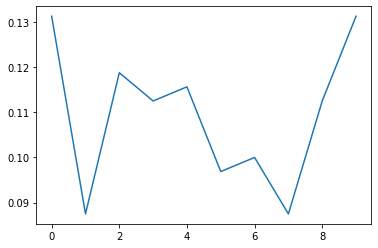

In [19]:
dfs = analysis.trial_dataframes
[d.mean_accuracy.plot() for d in dfs.values()]

In [15]:
import time
start = time.time()
analysis = tune.run(
    train_mnist,
    num_samples=20,
#     scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    config=search_space)
print(f"duration (s)= {start-time.time()}")
# Obtain a trial dataframe from all run trials of this `tune.run` call.
dfs = analysis.trial_dataframes

Trial name,status,loc,lr,momentum
train_mnist_da2d9_00000,PENDING,,2.45713e-10,0.117134
train_mnist_da2d9_00001,PENDING,,1.04919e-10,0.415506
train_mnist_da2d9_00002,PENDING,,9.79726e-05,0.119051
train_mnist_da2d9_00003,PENDING,,3.2261e-08,0.859474
train_mnist_da2d9_00004,PENDING,,0.0397615,0.168513
train_mnist_da2d9_00005,PENDING,,5.97809e-09,0.742749
train_mnist_da2d9_00006,PENDING,,0.0160429,0.2943
train_mnist_da2d9_00007,PENDING,,0.00171822,0.385603
train_mnist_da2d9_00008,PENDING,,0.000852025,0.362772
train_mnist_da2d9_00009,PENDING,,3.23372e-09,0.432817


(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warning

(pid=10646) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=10646) Failed to download (trying next):
(pid=10646) HTTP Error 503: Service Unavailable
(pid=10646) 
(pid=10646) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz


(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(


(pid=10640) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=10667) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=10640) Failed to download (trying next):
(pid=10640) HTTP Error 503: Service Unavailable
(pid=10640) 
(pid=10640) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=10646) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=10667) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=10681) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=10667) Failed to download (trying next):
(pid=10667) HTTP Error 503: Service Unavailable
(pid=10667) 
(pid=10667) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=10640) Downloading https://ossci-datasets.s3.amazona

  6%|▌         | 571392/9912422 [00:00<00:11, 819877.85it/s]


(pid=10681) Failed to download (trying next):
(pid=10681) HTTP Error 503: Service Unavailable
(pid=10681) 
(pid=10681) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=10667) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=10661) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=10661) Failed to download (trying next):
(pid=10661) HTTP Error 503: Service Unavailable
(pid=10661) 
(pid=10661) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz


 46%|████▌     | 4535296/9912422 [00:00<00:03, 1602016.93it/s]


(pid=10956) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=10681) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=10953) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=10957) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz


  0%|          | 1024/9912422 [00:00<16:14, 10173.33it/s]
9913344it [00:00, 13234907.15it/s]                            
  9%|▉         | 870400/9912422 [00:00<05:11, 29063.93it/s]


(pid=10956) Failed to download (trying next):
(pid=10956) HTTP Error 503: Service Unavailable
(pid=10956) 
(pid=10956) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=10953) Failed to download (trying next):
(pid=10953) HTTP Error 503: Service Unavailable
(pid=10953) 
(pid=10953) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=10646) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10661) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=10957) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz


 38%|███▊      | 3733504/9912422 [00:00<00:03, 2049130.58it/s]


(pid=10956) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=10953) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz


 14%|█▍        | 1366016/9912422 [00:00<00:07, 1071933.52it/s]


(pid=10646) 
(pid=10646) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=10646) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


 71%|███████▏  | 7063552/9912422 [00:01<00:00, 4167938.16it/s]
9913344it [00:01, 7392241.76it/s]                            
 30%|██▉       | 2926592/9912422 [00:00<00:03, 2219802.36it/s]


(pid=10667) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10646) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10646) 
(pid=10646) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz


  0%|          | 44032/9912422 [00:00<01:56, 84477.00it/s]
29696it [00:00, 436145.70it/s]           
  1%|          | 89088/9912422 [00:00<01:40, 97759.72it/s]


Trial name,status,loc,lr,momentum
train_mnist_da2d9_00000,RUNNING,,2.45713e-10,0.117134
train_mnist_da2d9_00001,RUNNING,,1.04919e-10,0.415506
train_mnist_da2d9_00002,RUNNING,,9.79726e-05,0.119051
train_mnist_da2d9_00003,RUNNING,,3.2261e-08,0.859474
train_mnist_da2d9_00004,RUNNING,,0.0397615,0.168513
train_mnist_da2d9_00005,RUNNING,,5.97809e-09,0.742749
train_mnist_da2d9_00006,RUNNING,,0.0160429,0.2943
train_mnist_da2d9_00007,RUNNING,,0.00171822,0.385603
train_mnist_da2d9_00008,PENDING,,0.000852025,0.362772
train_mnist_da2d9_00009,PENDING,,3.23372e-09,0.432817


  0%|          | 41984/9912422 [00:01<04:41, 35016.73it/s]
9913344it [00:02, 4812919.68it/s]                             
  1%|          | 113664/9912422 [00:00<01:15, 130547.37it/s]


(pid=10646) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=10646) Failed to download (trying next):
(pid=10646) HTTP Error 503: Service Unavailable
(pid=10646) 
(pid=10646) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=10640) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10667) 
(pid=10667) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz


  1%|          | 87040/9912422 [00:00<00:13, 715240.26it/s]


(pid=10646) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


 10%|█         | 1009664/9912422 [00:00<00:07, 1235398.28it/s]


(pid=10640) 
(pid=10640) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=10640) Failed to download (trying next):
(pid=10640) HTTP Error 503: Service Unavailable
(pid=10640) 
(pid=10640) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz


  8%|▊         | 123904/1648877 [00:00<00:04, 316632.31it/s]
9913344it [00:02, 4837336.05it/s]                             
 34%|███▍      | 559104/1648877 [00:00<00:02, 434776.81it/s]


(pid=10681) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10640) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


  6%|▌         | 566272/9912422 [00:01<00:22, 413694.48it/s]


(pid=10681) 
(pid=10681) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz


 69%|██████▊   | 1133568/1648877 [00:01<00:01, 512632.46it/s]
1649664it [00:01, 1535772.09it/s]                            
  7%|▋         | 653312/9912422 [00:02<00:47, 194649.29it/s]


(pid=10646) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10646) 
(pid=10646) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


 14%|█▍        | 1376256/9912422 [00:02<00:17, 480865.11it/s]
29696it [00:00, 487556.28it/s]           
 88%|████████▊ | 8711168/9912422 [00:01<00:00, 5418630.72it/s]


(pid=10646) Failed to download (trying next):
(pid=10646) HTTP Error 503: Service Unavailable
(pid=10646) 
(pid=10646) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=10640) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10640) 
(pid=10640) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=10640) Failed to download (trying next):
(pid=10640) HTTP Error 503: Service Unavailable
(pid=10640) 
(pid=10640) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=10646) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=10953) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10640) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


 17%|█▋        | 1655808/9912422 [00:03<00:11, 699598.00it/s]
9913344it [00:01, 5298811.58it/s]                             
 21%|██        | 2091008/9912422 [00:03<00:07, 1039508.96it/s]
5120it [00:00, 4820389.78it/s]          
 24%|██▍       | 2386944/9912422 [00:03<00:05, 1290238.78it/s]
(pid=10646) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=10646)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
 27%|██▋       | 2648064/9912422 [00:03<00:04, 1477336.50it/s]


(pid=10646) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10646) 
(pid=10681) Failed to download (trying next):
(pid=10681) HTTP Error 503: Service Unavailable
(pid=10681) 
(pid=10681) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=10953) 
(pid=10953) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=10953) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]
29696it [00:00, 751307.74it/s]           


(pid=10681) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=10953) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10953) 
(pid=10953) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz


 20%|██        | 2028544/9912422 [00:03<00:06, 1156061.83it/s]
1649664it [00:00, 3721780.72it/s]                             
29696it [00:00, 579164.93it/s]           
 41%|████      | 4040704/9912422 [00:04<00:02, 2571771.40it/s]


(pid=10953) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=10640) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10681) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10681) 
(pid=10681) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=10640) 
(pid=10640) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=10953) Failed to download (trying next):
(pid=10953) HTTP Error 503: Service Unavailable
(pid=10953) 
(pid=10953) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=10681) Failed to download (trying next):
(pid=10681) HTTP Error 503: Service Unavailable
(pid=10681) 
(pid=10681) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


 27%|██▋       | 2655232/9912422 [00:03<00:04, 1655782.09it/s]
(pid=10646) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=10646)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
 50%|████▉     | 4945920/9912422 [00:04<00:01, 3178001.11it/s]


(pid=10640) Failed to download (trying next):
(pid=10640) HTTP Error 503: Service Unavailable
(pid=10640) 
(pid=10640) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=10953) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=10640) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=10667) Failed to download (trying next):
(pid=10667) HTTP Error 503: Service Unavailable
(pid=10667) 
(pid=10667) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=10681) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


 62%|██████▏   | 6129664/9912422 [00:04<00:00, 3987264.43it/s]


(pid=10640) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10640) 
(pid=10667) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
Result for train_mnist_da2d9_00001:
  date: 2021-06-23_16-06-26
  done: false
  experiment_id: 1cf9d7388eb24336bbd9fd52e688cab0
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.028125
  node_ip: 192.168.1.106
  pid: 10646
  time_since_restore: 6.488731861114502
  time_this_iter_s: 6.488731861114502
  time_total_s: 6.488731861114502
  timestamp: 1624482386
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: da2d9_00001
  


5120it [00:00, 7172624.07it/s]          
  0%|          | 0/1648877 [00:00<?, ?it/s]
(pid=10640) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=10640)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
 41%|████      | 4073472/9912422 [00:04<00:02, 2684620.83it/s]
(pid=10640) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change.

Result for train_mnist_da2d9_00000:
  date: 2021-06-23_16-06-26
  done: false
  experiment_id: 35af84fcc78a469fb3dd6ee1dfae81d6
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.0875
  node_ip: 192.168.1.106
  pid: 10640
  time_since_restore: 6.422159671783447
  time_this_iter_s: 6.422159671783447
  time_total_s: 6.422159671783447
  timestamp: 1624482386
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: da2d9_00000
  
(pid=10667) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10667) 
(pid=10667) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz


 26%|██▌       | 421888/1648877 [00:00<00:01, 661278.50it/s]
9913344it [00:05, 1973863.86it/s]                             
 68%|██████▊   | 6707200/9912422 [00:04<00:00, 4477328.35it/s]


(pid=10667) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=10661) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10667) Failed to download (trying next):
(pid=10667) HTTP Error 503: Service Unavailable
(pid=10667) 
(pid=10667) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


 73%|███████▎  | 7224320/9912422 [00:04<00:00, 4642472.58it/s]
1649664it [00:00, 2151830.05it/s]                             
 81%|████████  | 8051712/9912422 [00:04<00:00, 5278418.56it/s]


(pid=10953) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10953) 
(pid=10953) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=10667) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=10661) 
(pid=10661) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=10953) Failed to download (trying next):
(pid=10953) HTTP Error 503: Service Unavailable
(pid=10953) 
(pid=10953) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz


 95%|█████████▌| 9461760/9912422 [00:05<00:00, 5789292.75it/s]
9913344it [00:05, 1948278.37it/s]                             


(pid=10661) Failed to download (trying next):
(pid=10661) HTTP Error 503: Service Unavailable
(pid=10661) 
(pid=10661) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=10956) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10681) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10953) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=10681) 
(pid=10681) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


1649664it [00:01, 1428247.24it/s]                             
  2%|▏         | 197632/9912422 [00:06<05:01, 32176.63it/s]


(pid=10661) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=10681) Failed to download (trying next):
(pid=10681) HTTP Error 503: Service Unavailable
(pid=10681) 
(pid=10681) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=10953) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10953) 


 32%|███▏      | 523264/1648877 [00:00<00:01, 855939.26it/s]
5120it [00:00, 3432678.47it/s]          


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_da2d9_00000,RUNNING,192.168.1.106:10640,2.45713e-10,0.117134,0.10625,5,7.59194
train_mnist_da2d9_00001,RUNNING,192.168.1.106:10646,1.04919e-10,0.415506,0.040625,5,7.68654
train_mnist_da2d9_00002,RUNNING,,9.79726e-05,0.119051,,,
train_mnist_da2d9_00003,RUNNING,,3.2261e-08,0.859474,,,
train_mnist_da2d9_00004,RUNNING,,0.0397615,0.168513,,,
train_mnist_da2d9_00005,RUNNING,,5.97809e-09,0.742749,,,
train_mnist_da2d9_00006,RUNNING,,0.0160429,0.2943,,,
train_mnist_da2d9_00007,RUNNING,,0.00171822,0.385603,,,
train_mnist_da2d9_00008,PENDING,,0.000852025,0.362772,,,
train_mnist_da2d9_00009,PENDING,,3.23372e-09,0.432817,,,


(pid=10953) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=10953)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
  2%|▏         | 205824/9912422 [00:06<05:02, 32093.76it/s]
29696it [00:00, 607248.97it/s]           
(pid=10953) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important

(pid=10661) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10661) 
(pid=10661) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=10681) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=10956) 
(pid=10956) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=10667) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10667) 
(pid=10667) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=10661) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=10956) Failed to download (trying next):
(pid=10956) HTTP Error 503: Service Unavailable
(pid=10956) 
(pid=10956) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz


  2%|▏         | 214016/9912422 [00:06<04:57, 32618.74it/s]
5120it [00:00, 3453101.22it/s]          
(pid=10681) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=10681)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
(pid=10681) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important 

(pid=10667) Failed to download (trying next):
(pid=10667) HTTP Error 503: Service Unavailable
(pid=10667) 
(pid=10667) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=10681) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10681) 
(pid=10661) Failed to download (trying next):
(pid=10661) HTTP Error 503: Service Unavailable
(pid=10661) 
(pid=10661) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
Result for train_mnist_da2d9_00007:
  date: 2021-06-23_16-06-28
  done: false
  experiment_id: d5de1217a20842acb11dfb51f264de32
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.146875
  node_ip: 192.168.1.106
  pid: 10953
  time_since_restore: 7.109820604324341
  time_this_iter_s: 7.109820604324341
  time_total_s: 7.109820604324341
  timestamp: 1624482388
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: da2d9_00007
  
(pid=10956) Downloadi

  2%|▏         | 222208/9912422 [00:06<04:58, 32444.85it/s]


(pid=10667) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Result for train_mnist_da2d9_00002:
  date: 2021-06-23_16-06-28
  done: false
  experiment_id: f2bae5bccd204bafbc7232f8cb0489f3
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.08125
  node_ip: 192.168.1.106
  pid: 10681
  time_since_restore: 8.062845230102539
  time_this_iter_s: 8.062845230102539
  time_total_s: 8.062845230102539
  timestamp: 1624482388
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: da2d9_00002
  
(pid=10956) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10956) 
(pid=10956) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz


  0%|          | 0/1648877 [00:00<?, ?it/s]
29696it [00:00, 689713.89it/s]           
5120it [00:00, 4824721.74it/s]          
  2%|▏         | 230400/9912422 [00:07<05:01, 32100.37it/s]
(pid=10667) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=10667)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
(pid=10667) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an expe

(pid=10667) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10667) 
(pid=10956) Failed to download (trying next):
(pid=10956) HTTP Error 503: Service Unavailable
(pid=10956) 
(pid=10956) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


  2%|▏         | 238592/9912422 [00:07<05:07, 31460.10it/s]
1649664it [00:00, 5249782.48it/s]                           


(pid=10661) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10956) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
Result for train_mnist_da2d9_00004:
(pid=10661) 
(pid=10661) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
  date: 2021-06-23_16-06-29
  done: false
  experiment_id: 9afb5080d4a14d118b4618cc8aa75cf8
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.30625
  node_ip: 192.168.1.106
  pid: 10667
  time_since_restore: 8.800606727600098
  time_this_iter_s: 8.800606727600098
  time_total_s: 8.800606727600098
  timestamp: 1624482389
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: da2d9_00004
  


  5%|▌         | 86016/1648877 [00:00<00:02, 693655.67it/s]


(pid=10661) Failed to download (trying next):
(pid=10661) HTTP Error 503: Service Unavailable
(pid=10661) 
(pid=10661) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz


 98%|█████████▊| 1618944/1648877 [00:00<00:00, 1246149.55it/s]
1649664it [00:00, 4781115.65it/s]                             


Result for train_mnist_da2d9_00001:
  date: 2021-06-23_16-06-29
  done: true
  experiment_id: 1cf9d7388eb24336bbd9fd52e688cab0
  experiment_tag: 1_lr=1.0492e-10,momentum=0.41551
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.040625
  node_ip: 192.168.1.106
  pid: 10646
  time_since_restore: 9.490981340408325
  time_this_iter_s: 0.36724281311035156
  time_total_s: 9.490981340408325
  timestamp: 1624482389
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: da2d9_00001
  
(pid=10956) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10661) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=10956) 
(pid=10956) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=10956) Failed to download (trying next):
(pid=10956) HTTP Error 503: Service Unavailable
(pid=10956) 
(pid=10956) Downloading https://ossci

  3%|▎         | 263168/9912422 [00:08<04:53, 32919.37it/s]


(pid=10661) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10661) 
(pid=10956) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz


5120it [00:00, 5530475.53it/s]          
(pid=10661) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=10661)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
  3%|▎         | 271360/9912422 [00:08<04:57, 32368.64it/s]
(pid=10661) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important 

(pid=10956) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10956) 
Result for train_mnist_da2d9_00003:
  date: 2021-06-23_16-06-30
  done: false
  experiment_id: 6391abde39194029bb8b764855e12e7d
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.0625
  node_ip: 192.168.1.106
  pid: 10661
  time_since_restore: 9.538561344146729
  time_this_iter_s: 9.538561344146729
  time_total_s: 9.538561344146729
  timestamp: 1624482390
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: da2d9_00003
  


(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(


Result for train_mnist_da2d9_00006:
  date: 2021-06-23_16-06-30
  done: false
  experiment_id: a504b63bd91140c1a5492d61df335a4b
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.34375
  node_ip: 192.168.1.106
  pid: 10956
  time_since_restore: 9.570634841918945
  time_this_iter_s: 9.570634841918945
  time_total_s: 9.570634841918945
  timestamp: 1624482390
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: da2d9_00006
  


  3%|▎         | 287744/9912422 [00:09<06:52, 23320.11it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
  3%|▎         | 312320/9912422 [00:09<06:10, 25925.88it/s]


Result for train_mnist_da2d9_00002:
  date: 2021-06-23_16-06-31
  done: true
  experiment_id: f2bae5bccd204bafbc7232f8cb0489f3
  experiment_tag: 2_lr=9.7973e-05,momentum=0.11905
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.084375
  node_ip: 192.168.1.106
  pid: 10681
  time_since_restore: 11.16179609298706
  time_this_iter_s: 0.2507665157318115
  time_total_s: 11.16179609298706
  timestamp: 1624482391
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: da2d9_00002
  
Result for train_mnist_da2d9_00007:
  date: 2021-06-23_16-06-32
  done: true
  experiment_id: d5de1217a20842acb11dfb51f264de32
  experiment_tag: 7_lr=0.0017182,momentum=0.3856
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.2625
  node_ip: 192.168.1.106
  pid: 10953
  time_since_restore: 10.623141765594482
  time_this_iter_s: 0.27982401847839355
  time_total_s: 10.623141765594482
  timestamp: 1624482392
  timesteps_since_restore: 0
  training_iter

  3%|▎         | 336896/9912422 [00:10<04:54, 32492.81it/s]


(pid=11249) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=11249) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=11252) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz


  3%|▎         | 345088/9912422 [00:10<04:44, 33607.98it/s]


(pid=11249) Failed to download (trying next):
(pid=11249) HTTP Error 503: Service Unavailable
(pid=11249) 
(pid=11249) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=11252) Failed to download (trying next):
(pid=11252) HTTP Error 503: Service Unavailable
(pid=11252) 
(pid=11252) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
Result for train_mnist_da2d9_00004:
  date: 2021-06-23_16-06-32
  done: true
  experiment_id: 9afb5080d4a14d118b4618cc8aa75cf8
  experiment_tag: 4_lr=0.039761,momentum=0.16851
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.8125
  node_ip: 192.168.1.106
  pid: 10667
  time_since_restore: 12.099262952804565
  time_this_iter_s: 0.2860727310180664
  time_total_s: 12.099262952804565
  timestamp: 1624482392
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: da2d9_00004
  


  4%|▎         | 353280/9912422 [00:10<04:50, 32861.23it/s]


(pid=11249) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=11252) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz


  1%|          | 86016/9912422 [00:00<00:12, 814487.53it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_da2d9_00003,RUNNING,192.168.1.106:10661,3.2261e-08,0.859474,0.065625,8,12.0499
train_mnist_da2d9_00005,RUNNING,,5.97809e-09,0.742749,,,
train_mnist_da2d9_00006,RUNNING,192.168.1.106:10956,0.0160429,0.2943,0.725,7,11.6459
train_mnist_da2d9_00008,RUNNING,,0.000852025,0.362772,,,
train_mnist_da2d9_00009,RUNNING,,3.23372e-09,0.432817,,,
train_mnist_da2d9_00010,RUNNING,,0.000103844,0.11632,,,
train_mnist_da2d9_00011,RUNNING,,4.62144e-06,0.230136,,,
train_mnist_da2d9_00012,RUNNING,,0.00104378,0.628893,,,
train_mnist_da2d9_00013,PENDING,,1.87117e-07,0.593878,,,
train_mnist_da2d9_00014,PENDING,,3.11691e-08,0.475314,,,



(raylet)   warnings.warn(
  9%|▉         | 874496/9912422 [00:00<00:08, 1046266.35it/s]


(pid=11276) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=11276) Failed to download (trying next):
(pid=11276) HTTP Error 503: Service Unavailable
(pid=11276) 
(pid=11276) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=11253) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz


 81%|████████  | 8045568/9912422 [00:00<00:00, 3785266.79it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
 21%|██        | 2075648/9912422 [00:00<00:04, 1871659.29it/s]


(pid=11253) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=11276) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=11253) Failed to download (trying next):
(pid=11253) HTTP Error 503: Service Unavailable
(pid=11253) 
(pid=11253) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz


  4%|▍         | 386048/9912422 [00:11<04:51, 32708.00it/s]
9913344it [00:00, 13595103.88it/s]                            
 27%|██▋       | 2719744/9912422 [00:00<00:03, 2327332.93it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
 35%|███▍      | 3450880/9912422 [00:00<00:02, 2914748.21it/s]


(pid=11252) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
Result for train_mnist_da2d9_00003:
  date: 2021-06-23_16-06-33
  done: true
  experiment_id: 6391abde39194029bb8b764855e12e7d
  experiment_tag: 3_lr=3.2261e-08,momentum=0.85947
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.04375
  node_ip: 192.168.1.106
  pid: 10661
  time_since_restore: 12.7455415725708
  time_this_iter_s: 0.3698275089263916
  time_total_s: 12.7455415725708
  timestamp: 1624482393
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: da2d9_00003
  
(pid=11253) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/9912422 [00:00<?, ?it/s]


Result for train_mnist_da2d9_00006:
  date: 2021-06-23_16-06-33
  done: true
  experiment_id: a504b63bd91140c1a5492d61df335a4b
  experiment_tag: 6_lr=0.016043,momentum=0.2943
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.846875
  node_ip: 192.168.1.106
  pid: 10956
  time_since_restore: 12.630165338516235
  time_this_iter_s: 0.39086318016052246
  time_total_s: 12.630165338516235
  timestamp: 1624482393
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: da2d9_00006
  


 79%|███████▊  | 7785472/9912422 [00:01<00:00, 6450672.70it/s]


(pid=11252) 
(pid=11252) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=11252) Failed to download (trying next):
(pid=11252) HTTP Error 503: Service Unavailable
(pid=11252) 
(pid=11252) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz


  4%|▍         | 410624/9912422 [00:12<04:58, 31782.18it/s]
9913344it [00:01, 6404385.83it/s]                             
 48%|████▊     | 4739072/9912422 [00:00<00:01, 2974457.83it/s]


(pid=11249) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11252) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=11342) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz


  4%|▍         | 427008/9912422 [00:13<04:49, 32785.68it/s]
29696it [00:00, 397371.31it/s]           
9913344it [00:01, 9532651.93it/s]                             
 11%|█▏        | 1131520/9912422 [00:00<00:06, 1333718.21it/s]


(pid=11342) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=11249) 
(pid=11249) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=11252) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11252) 
(pid=11252) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=11276) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11342) Failed to download (trying next):
(pid=11342) HTTP Error 503: Service Unavailable
(pid=11342) 
(pid=11342) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=11249) Failed to download (trying next):
(pid=11249) HTTP Error 503: Service Unavailable
(pid=11249) 
(pid=11249) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=11252) Failed to download (trying next):
(pid=11252) HTTP Error 503: 

 18%|█▊        | 1740800/9912422 [00:01<00:04, 1704814.40it/s]


(pid=11249) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=11276) 
(pid=11276) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=11363) Failed to download (trying next):
(pid=11363) HTTP Error 503: Service Unavailable
(pid=11363) 
(pid=11363) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=11276) Failed to download (trying next):
(pid=11276) HTTP Error 503: Service Unavailable
(pid=11276) 
(pid=11276) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=11347) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz


 30%|██▉       | 2941952/9912422 [00:01<00:02, 2480178.95it/s]


(pid=11363) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=11249) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11249) 
(pid=11249) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=11276) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=11249) Failed to download (trying next):
(pid=11249) HTTP Error 503: Service Unavailable
(pid=11249) 
(pid=11249) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


29696it [00:00, 570717.93it/s]           
 37%|███▋      | 609280/1648877 [00:00<00:00, 1074597.38it/s]
29696it [00:00, 567886.83it/s]           
  1%|▏         | 147456/9912422 [00:00<00:31, 309094.94it/s]


(pid=11276) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11276) 
(pid=11276) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=11276) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


 11%|█         | 1069056/9912422 [00:00<00:06, 1313084.70it/s]


(pid=11276) Failed to download (trying next):
(pid=11276) HTTP Error 503: Service Unavailable
(pid=11276) 
(pid=11276) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=11252) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 10%|█         | 1035264/9912422 [00:00<00:12, 737036.82it/s]
1649664it [00:00, 1842193.04it/s]                             
 14%|█▍        | 1383424/9912422 [00:00<00:08, 948258.16it/s]


(pid=11252) 
(pid=11252) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=11252) Failed to download (trying next):
(pid=11252) HTTP Error 503: Service Unavailable
(pid=11252) 
(pid=11252) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz


  5%|▍         | 484352/9912422 [00:14<04:51, 32288.49it/s]
9913344it [00:02, 3720610.83it/s]                             
 31%|███       | 3037184/9912422 [00:01<00:02, 2615334.25it/s]


(pid=11253) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 57%|█████▋    | 5648384/9912422 [00:01<00:00, 4355373.44it/s]


(pid=11253) 
(pid=11253) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=11253) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]
9913344it [00:02, 4805161.71it/s]                             
 62%|██████▏   | 6180864/9912422 [00:01<00:00, 4601817.73it/s]
29696it [00:00, 1176414.41it/s]          
 73%|███████▎  | 7196672/9912422 [00:01<00:00, 5446163.07it/s]


(pid=11342) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11253) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11253) 
(pid=11253) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz


 94%|█████████▍| 9321472/9912422 [00:02<00:00, 7030103.40it/s]
9913344it [00:02, 4668314.30it/s]                             


(pid=11253) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=11253) Failed to download (trying next):
(pid=11253) HTTP Error 503: Service Unavailable
(pid=11253) 
(pid=11253) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=11342) 
(pid=11342) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=11342) Failed to download (trying next):
(pid=11342) HTTP Error 503: Service Unavailable
(pid=11342) 
(pid=11342) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=11347) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11363) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


9913344it [00:02, 4320746.72it/s]                             
  5%|▌         | 533504/9912422 [00:16<04:55, 31723.08it/s]


(pid=11363) 
(pid=11363) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=11347) 
(pid=11347) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=11363) Failed to download (trying next):
(pid=11363) HTTP Error 503: Service Unavailable
(pid=11363) 
(pid=11363) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=11347) Failed to download (trying next):
(pid=11347) HTTP Error 503: Service Unavailable
(pid=11347) 
(pid=11347) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz


  6%|▋         | 623616/9912422 [00:18<04:27, 34686.32it/s]


(pid=11276) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=11253) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=11342) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=11347) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=11363) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=11252) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=11249) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/ra

  0%|          | 0/1648877 [00:00<?, ?it/s]
5120it [00:00, 2000450.53it/s]          
(pid=11252) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=11252)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
  0%|          | 0/1648877 [00:00<?, ?it/s]
29696it [00:00, 737848.85it/s]           
29696it [00:00, 673574.62it/s]           
29696it [00:00, 667488.66it/s]           
(pid=11252) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: 

(pid=11252) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11252) 
(pid=11342) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11342) 
(pid=11342) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=11347) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11347) 
(pid=11347) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=11363) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11363) 
(pid=11363) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=11342) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=11347) Failed to download (trying next):
(pid=11347) HTTP Error 503: Service Unavailable
(pid=11347) 
(pid=11347) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-image

 17%|█▋        | 278528/1648877 [00:00<00:01, 799744.06it/s]


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_da2d9_00005,RUNNING,,5.97809e-09,0.742749,,,
train_mnist_da2d9_00008,RUNNING,192.168.1.106:11252,0.000852025,0.362772,0.13125,1,9.05991
train_mnist_da2d9_00009,RUNNING,,3.23372e-09,0.432817,,,
train_mnist_da2d9_00010,RUNNING,,0.000103844,0.11632,,,
train_mnist_da2d9_00011,RUNNING,,4.62144e-06,0.230136,,,
train_mnist_da2d9_00012,RUNNING,,0.00104378,0.628893,,,
train_mnist_da2d9_00013,RUNNING,,1.87117e-07,0.593878,,,
train_mnist_da2d9_00014,RUNNING,,3.11691e-08,0.475314,,,
train_mnist_da2d9_00015,PENDING,,3.29901e-05,0.366817,,,
train_mnist_da2d9_00016,PENDING,,4.06915e-07,0.613989,,,


(pid=11342) Failed to download (trying next):
(pid=11342) HTTP Error 503: Service Unavailable
(pid=11342) 
(pid=11342) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


 94%|█████████▍| 1549312/1648877 [00:00<00:00, 1524957.45it/s]


(pid=11347) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=11363) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=11253) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11342) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=11253) 
(pid=11253) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


1649664it [00:00, 3159735.66it/s]                             
 76%|███████▌  | 1253376/1648877 [00:00<00:00, 1511570.43it/s]


(pid=11249) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11276) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11253) Failed to download (trying next):
(pid=11253) HTTP Error 503: Service Unavailable
(pid=11253) 
(pid=11253) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz


1649664it [00:00, 2419891.99it/s]                             
1649664it [00:00, 2449993.17it/s]                             
  0%|          | 0/1648877 [00:00<?, ?it/s]


(pid=11249) 
(pid=11249) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=11276) 
(pid=11276) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=11249) Failed to download (trying next):
(pid=11249) HTTP Error 503: Service Unavailable
(pid=11249) 
(pid=11249) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=11276) Failed to download (trying next):
(pid=11276) HTTP Error 503: Service Unavailable
(pid=11276) 
(pid=11276) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz


 58%|█████▊    | 958464/1648877 [00:00<00:00, 832405.88it/s]
1649664it [00:00, 4705259.50it/s]                             
 68%|██████▊   | 1114112/1648877 [00:00<00:00, 1316915.42it/s]


(pid=11253) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=11249) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=11276) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=11342) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 90%|████████▉ | 1480704/1648877 [00:00<00:00, 1091597.17it/s]
5120it [00:00, 5925727.51it/s]          
(pid=11253) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=11253)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
1649664it [00:00, 2816381.17it/s]                             
1649664it [00:00, 2971777.41it/s]                             
(pid=11253) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensor

(pid=11342) 
(pid=11342) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=11253) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11253) 
(pid=11347) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11363) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11342) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=11347) 
(pid=11347) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=11363) 
(pid=11363) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=11249) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11249) 
(pid=11276) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11276) 


(pid=11249) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=11249)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
(pid=11249) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(p

(pid=11342) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11342) 
(pid=11347) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=11363) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=11347) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11347) 
(pid=11363) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11363) 
Result for train_mnist_da2d9_00011:
  date: 2021-06-23_16-06-42
  done: false
  experiment_id: 337be85104054d7e940daf09cd2898fd
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.075
  node_ip: 192.168.1.106
  pid: 11253
  time_since_restore: 9.490989208221436
  time_this_iter_s: 9.490989208221436
  time_total_s: 9.490989208221436
  timestamp: 1624482402
  timesteps_since_restore: 0
 

(pid=11347) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=11347)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=11363) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=11363)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for train_mnist_da2d9_00010:
  date: 2021-06-23_16-06-42
  done: false
  experiment_id: 9c2d951e450544a8b0d3bca52f03d3f9
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.065625
  node_ip: 192.168.1.106
  pid: 11276
  time_since_restore: 9.735070705413818
  time_this_iter_s: 9.735070705413818
  time_total_s: 9.735070705413818
  timestamp: 1624482402
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: da2d9_00010
  
Result for train_mnist_da2d9_00009:
  date: 2021-06-23_16-06-42
  done: false
  experiment_id: e7be97bcbbd04406b5364e3bfb6dbdf4
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.146875
  node_ip: 192.168.1.106
  pid: 11249
  time_since_restore: 10.78112244606018
  time_this_iter_s: 10.78112244606018
  time_total_s: 10.78112244606018
  timestamp: 1624482402
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: da2d9_00009
  
Result for train_mnist_da2d9_00012:
  date: 2021-06-23_16-06-43
  do

  7%|▋         | 689152/9912422 [00:21<05:26, 28234.13it/s]


Result for train_mnist_da2d9_00013:
  date: 2021-06-23_16-06-43
  done: false
  experiment_id: 8d3d98ec727b4d3f8e78fb1e61fd20b6
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.103125
  node_ip: 192.168.1.106
  pid: 11347
  time_since_restore: 8.209262609481812
  time_this_iter_s: 8.209262609481812
  time_total_s: 8.209262609481812
  timestamp: 1624482403
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: da2d9_00013
  
Result for train_mnist_da2d9_00014:
  date: 2021-06-23_16-06-43
  done: false
  experiment_id: def53450d0b24c9faddd2799a627965d
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.109375
  node_ip: 192.168.1.106
  pid: 11363
  time_since_restore: 8.136679410934448
  time_this_iter_s: 8.136679410934448
  time_total_s: 8.136679410934448
  timestamp: 1624482403
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: da2d9_00014
  


  7%|▋         | 705536/9912422 [00:21<06:05, 25220.90it/s]


Result for train_mnist_da2d9_00008:
  date: 2021-06-23_16-06-43
  done: true
  experiment_id: 2b952687132a4896a1f1cfdb2006cd65
  experiment_tag: 8_lr=0.00085202,momentum=0.36277
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.209375
  node_ip: 192.168.1.106
  pid: 11252
  time_since_restore: 11.631062984466553
  time_this_iter_s: 0.30151796340942383
  time_total_s: 11.631062984466553
  timestamp: 1624482403
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: da2d9_00008
  


  7%|▋         | 730112/9912422 [00:22<05:01, 30432.59it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
  8%|▊         | 762880/9912422 [00:23<04:46, 31980.69it/s]


Result for train_mnist_da2d9_00012:
  date: 2021-06-23_16-06-45
  done: true
  experiment_id: e76f250729ef4e2390f351ecd09e4365
  experiment_tag: 12_lr=0.0010438,momentum=0.62889
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.371875
  node_ip: 192.168.1.106
  pid: 11342
  time_since_restore: 11.040782451629639
  time_this_iter_s: 0.2930421829223633
  time_total_s: 11.040782451629639
  timestamp: 1624482405
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: da2d9_00012
  
Result for train_mnist_da2d9_00011:
  date: 2021-06-23_16-06-45
  done: true
  experiment_id: 337be85104054d7e940daf09cd2898fd
  experiment_tag: 11_lr=4.6214e-06,momentum=0.23014
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.090625
  node_ip: 192.168.1.106
  pid: 11253
  time_since_restore: 12.598389625549316
  time_this_iter_s: 0.31696319580078125
  time_total_s: 12.598389625549316
  timestamp: 1624482405
  timesteps_since_restore: 0
  traini

  8%|▊         | 795648/9912422 [00:24<03:52, 39235.63it/s]


(pid=11509) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Result for train_mnist_da2d9_00010:
  date: 2021-06-23_16-06-46
  done: true
  experiment_id: 9c2d951e450544a8b0d3bca52f03d3f9
  experiment_tag: 10_lr=0.00010384,momentum=0.11632
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.078125
  node_ip: 192.168.1.106
  pid: 11276
  time_since_restore: 13.023104190826416
  time_this_iter_s: 0.3282928466796875
  time_total_s: 13.023104190826416
  timestamp: 1624482406
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: da2d9_00010
  
Result for train_mnist_da2d9_00009:
  date: 2021-06-23_16-06-46
  done: true
  experiment_id: e7be97bcbbd04406b5364e3bfb6dbdf4
  experiment_tag: 9_lr=3.2337e-09,momentum=0.43282
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.16875
  node_ip: 192.168.1.106
  pid: 11249
  time_since_restore: 14.02875566482544
  time_this_iter_s: 0.39281702041625977
  time_total_s

  8%|▊         | 803840/9912422 [00:24<04:27, 34044.27it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
  8%|▊         | 812032/9912422 [00:24<04:07, 36716.21it/s]


(pid=11509) Failed to download (trying next):
(pid=11509) HTTP Error 503: Service Unavailable
(pid=11509) 
(pid=11509) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz


(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
  8%|▊         | 820224/9912422 [00:24<04:19, 34981.43it/s]


(pid=11509) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz


(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warning

(pid=11509) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11533) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=11539) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz


  9%|▊         | 852992/9912422 [00:25<04:32, 33296.74it/s]


(pid=11533) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=11537) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=11539) Failed to download (trying next):
(pid=11539) HTTP Error 503: Service Unavailable
(pid=11539) 
(pid=11539) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=11536) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=11537) Failed to download (trying next):
(pid=11537) HTTP Error 503: Service Unavailable
(pid=11537) 
(pid=11537) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=11509) 
(pid=11509) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=11533) Failed to download (trying next):
(pid=11533) HTTP Error 503: Service Unavailable
(pid=11533) 
(pid=11533) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-id

  9%|▊         | 861184/9912422 [00:26<04:23, 34317.62it/s]


(pid=11509) Failed to download (trying next):
(pid=11509) HTTP Error 503: Service Unavailable
(pid=11509) 
(pid=11509) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=11539) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=11533) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=11537) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=11536) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=11509) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


  1%|          | 89088/9912422 [00:00<00:13, 741185.81it/s]
29696it [00:00, 606867.30it/s]           
  1%|          | 77824/9912422 [00:00<00:15, 621083.97it/s]


(pid=11509) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11509) 
(pid=11509) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=11509) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


  4%|▍         | 407552/9912422 [00:00<00:11, 846098.74it/s]


(pid=11509) Failed to download (trying next):
(pid=11509) HTTP Error 503: Service Unavailable
(pid=11509) 
(pid=11509) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


  9%|▉         | 902144/9912422 [00:27<04:38, 32313.29it/s]
9913344it [00:00, 11078035.51it/s]                            
 10%|█         | 1000448/9912422 [00:00<00:07, 1134097.35it/s]


(pid=11509) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=11539) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 19%|█▉        | 1862656/9912422 [00:01<00:04, 1652734.53it/s]


(pid=11539) 
(pid=11539) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=11539) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


1649664it [00:00, 4722856.32it/s]                            
  9%|▉         | 926720/9912422 [00:28<04:31, 33051.86it/s]
29696it [00:00, 1268784.65it/s]          
 48%|████▊     | 4769792/9912422 [00:01<00:01, 3639097.58it/s]


(pid=11509) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11509) 
(pid=11509) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=11539) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11539) 
(pid=11539) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=11509) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz


 61%|██████    | 6042624/9912422 [00:01<00:00, 4074324.64it/s]


(pid=11539) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=11509) Failed to download (trying next):
(pid=11509) HTTP Error 503: Service Unavailable
(pid=11509) 
(pid=11509) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=11539) Failed to download (trying next):
(pid=11539) HTTP Error 503: Service Unavailable
(pid=11539) 
(pid=11539) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


 71%|███████   | 6999040/9912422 [00:02<00:00, 4306534.50it/s]


(pid=11509) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=11539) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


 80%|███████▉  | 7921664/9912422 [00:02<00:00, 4383703.62it/s]
5120it [00:00, 2249145.00it/s]          


(pid=11509) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11509) 


 10%|▉         | 951296/9912422 [00:28<04:36, 32429.46it/s]
(pid=11509) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=11509)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
 41%|████      | 4045824/9912422 [00:02<00:02, 2209112.96it/s]
(pid=11509) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them f

Result for train_mnist_da2d9_00015:
  date: 2021-06-23_16-06-50
  done: false
  experiment_id: d056dbc8fb6046dbb00e049f64a4cdee
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.15
  node_ip: 192.168.1.106
  pid: 11509
  time_since_restore: 5.01018214225769
  time_this_iter_s: 5.01018214225769
  time_total_s: 5.01018214225769
  timestamp: 1624482410
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: da2d9_00015
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_da2d9_00005,RUNNING,,5.97809e-09,0.742749,,,
train_mnist_da2d9_00015,RUNNING,192.168.1.106:11509,3.29901e-05,0.366817,0.15,1,5.01018
train_mnist_da2d9_00016,RUNNING,,4.06915e-07,0.613989,,,
train_mnist_da2d9_00017,RUNNING,,6.05094e-05,0.716535,,,
train_mnist_da2d9_00018,RUNNING,,8.35054e-10,0.453282,,,
train_mnist_da2d9_00019,RUNNING,,4.79413e-09,0.497458,,,
train_mnist_da2d9_00000,TERMINATED,,2.45713e-10,0.117134,0.1,10,9.61623
train_mnist_da2d9_00001,TERMINATED,,1.04919e-10,0.415506,0.040625,10,9.49098
train_mnist_da2d9_00002,TERMINATED,,9.79726e-05,0.119051,0.084375,10,11.1618
train_mnist_da2d9_00003,TERMINATED,,3.2261e-08,0.859474,0.04375,10,12.7455


(pid=11537) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 48%|████▊     | 4734976/9912422 [00:02<00:02, 2142589.89it/s]
9913344it [00:02, 3662680.96it/s]                             
9913344it [00:02, 3680892.46it/s]                             
 53%|█████▎    | 5265408/9912422 [00:02<00:02, 2302974.34it/s]


(pid=11533) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11537) 
(pid=11537) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz


 62%|██████▏   | 6100992/9912422 [00:03<00:01, 2472103.81it/s]


(pid=11537) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=11533) 
(pid=11533) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=11539) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11539) 
(pid=11539) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


 10%|▉         | 984064/9912422 [00:29<04:26, 33446.00it/s]
1649664it [00:00, 1664502.96it/s]                             
  0%|          | 0/28881 [00:00<?, ?it/s]
29696it [00:00, 694095.51it/s]           
 68%|██████▊   | 6692864/9912422 [00:03<00:01, 2425679.32it/s]


(pid=11533) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=11537) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11537) 
(pid=11537) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=11539) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=11533) Failed to download (trying next):
(pid=11533) HTTP Error 503: Service Unavailable
(pid=11533) 
(pid=11533) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=11537) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


 75%|███████▌  | 7441408/9912422 [00:03<00:00, 2639953.36it/s]


(pid=11539) Failed to download (trying next):
(pid=11539) HTTP Error 503: Service Unavailable
(pid=11539) 
(pid=11539) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=11537) Failed to download (trying next):
(pid=11537) HTTP Error 503: Service Unavailable
(pid=11537) 
(pid=11537) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=11533) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


 83%|████████▎ | 8207360/9912422 [00:03<00:00, 2746102.21it/s]


(pid=11539) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=11537) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=11533) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11533) 
(pid=11533) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz


 10%|█         | 1008640/9912422 [00:30<04:31, 32763.62it/s]
29696it [00:00, 708623.54it/s]           
5120it [00:00, 7800521.79it/s]          
(pid=11539) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=11539)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
 87%|████████▋ | 8607744/9912422 [00:04<00:00, 2881645.86it/s]
(pid=11539) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associa

(pid=11539) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11539) 
(pid=11533) Failed to download (trying next):
(pid=11533) HTTP Error 503: Service Unavailable
(pid=11533) 
(pid=11533) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


 97%|█████████▋| 9650176/9912422 [00:04<00:00, 3051785.17it/s]


(pid=11533) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
Result for train_mnist_da2d9_00016:
  date: 2021-06-23_16-06-52
  done: false
  experiment_id: 41f52aa854cd4c61b7fe0b4679cceafd
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.090625
  node_ip: 192.168.1.106
  pid: 11539
  time_since_restore: 5.042693853378296
  time_this_iter_s: 5.042693853378296
  time_total_s: 5.042693853378296
  timestamp: 1624482412
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: da2d9_00016
  


 52%|█████▏    | 852992/1648877 [00:00<00:00, 1169703.88it/s]
9913344it [00:04, 2222590.97it/s]                             
  0%|          | 0/1648877 [00:00<?, ?it/s]
1649664it [00:00, 3809477.63it/s]                             


(pid=11536) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11537) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
Result for train_mnist_da2d9_00015:
  date: 2021-06-23_16-06-53
  done: true
  experiment_id: d056dbc8fb6046dbb00e049f64a4cdee
  experiment_tag: 15_lr=3.299e-05,momentum=0.36682
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.1375
  node_ip: 192.168.1.106
  pid: 11509
  time_since_restore: 7.0838212966918945
  time_this_iter_s: 0.2227177619934082
  time_total_s: 7.0838212966918945
  timestamp: 1624482413
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: da2d9_00015
  
(pid=11537) 
(pid=11537) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


 33%|███▎      | 538624/1648877 [00:00<00:01, 877893.79it/s]


(pid=11537) Failed to download (trying next):
(pid=11537) HTTP Error 503: Service Unavailable
(pid=11537) 
(pid=11537) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=11533) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11536) 
(pid=11536) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz


1649664it [00:00, 5438180.10it/s]                           
 11%|█         | 1041408/9912422 [00:31<04:33, 32429.30it/s]


(pid=11533) 
(pid=11533) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=11537) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=11533) Failed to download (trying next):
(pid=11533) HTTP Error 503: Service Unavailable
(pid=11533) 
(pid=11533) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=11536) Failed to download (trying next):
(pid=11536) HTTP Error 503: Service Unavailable
(pid=11536) 
(pid=11536) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=11537) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11537) 
(pid=11533) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=11536) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz t

5120it [00:00, 7877783.01it/s]          
(pid=11537) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=11537)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
(pid=11537) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at 

Result for train_mnist_da2d9_00017:
  date: 2021-06-23_16-06-53
  done: false
  experiment_id: da6036576cb446aabc155d2f53204148
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.165625
  node_ip: 192.168.1.106
  pid: 11537
  time_since_restore: 6.024798154830933
  time_this_iter_s: 6.024798154830933
  time_total_s: 6.024798154830933
  timestamp: 1624482413
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: da2d9_00017
  
(pid=11533) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11533) 
(pid=11536) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11536) 
(pid=11536) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=11536) Failed to download (trying next):
(pid=11536) HTTP Error 503: Service Unavailable
(pid=11536) 
(pid=11536) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]
5120it [00:00, 4125016.61it/s]          
(pid=11533) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=11533)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
29696it [00:00, 699631.81it/s]           
(pid=11533) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them

Result for train_mnist_da2d9_00019:
  date: 2021-06-23_16-06-54
  done: false
  experiment_id: 88a1753311c94779a32d7e554b9289fd
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.059375
  node_ip: 192.168.1.106
  pid: 11533
  time_since_restore: 6.484375715255737
  time_this_iter_s: 6.484375715255737
  time_total_s: 6.484375715255737
  timestamp: 1624482414
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: da2d9_00019
  
(pid=11536) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


 11%|█         | 1082368/9912422 [00:32<04:37, 31797.53it/s]
1649664it [00:00, 4299726.09it/s]                             


(pid=11536) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11536) 
(pid=11536) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
Result for train_mnist_da2d9_00016:
  date: 2021-06-23_16-06-54
  done: true
  experiment_id: 41f52aa854cd4c61b7fe0b4679cceafd
  experiment_tag: 16_lr=4.0691e-07,momentum=0.61399
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.1125
  node_ip: 192.168.1.106
  pid: 11539
  time_since_restore: 7.132564067840576
  time_this_iter_s: 0.20087599754333496
  time_total_s: 7.132564067840576
  timestamp: 1624482414
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: da2d9_00016
  
(pid=11536) Failed to download (trying next):
(pid=11536) HTTP Error 503: Service Unavailable
(pid=11536) 
(pid=11536) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz


 11%|█         | 1090560/9912422 [00:33<04:35, 32034.50it/s]


(pid=11536) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz


 11%|█         | 1106944/9912422 [00:33<04:55, 29776.69it/s]


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_da2d9_00005,RUNNING,,5.97809e-09,0.742749,,,
train_mnist_da2d9_00017,RUNNING,192.168.1.106:11537,6.05094e-05,0.716535,0.209375,9,8.04964
train_mnist_da2d9_00018,RUNNING,,8.35054e-10,0.453282,,,
train_mnist_da2d9_00019,RUNNING,192.168.1.106:11533,4.79413e-09,0.497458,0.065625,10,8.34015
train_mnist_da2d9_00000,TERMINATED,,2.45713e-10,0.117134,0.1,10,9.61623
train_mnist_da2d9_00001,TERMINATED,,1.04919e-10,0.415506,0.040625,10,9.49098
train_mnist_da2d9_00002,TERMINATED,,9.79726e-05,0.119051,0.084375,10,11.1618
train_mnist_da2d9_00003,TERMINATED,,3.2261e-08,0.859474,0.04375,10,12.7455
train_mnist_da2d9_00004,TERMINATED,,0.0397615,0.168513,0.8125,10,12.0993
train_mnist_da2d9_00006,TERMINATED,,0.0160429,0.2943,0.846875,10,12.6302


Result for train_mnist_da2d9_00019:
  date: 2021-06-23_16-06-56
  done: true
  experiment_id: 88a1753311c94779a32d7e554b9289fd
  experiment_tag: 19_lr=4.7941e-09,momentum=0.49746
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.065625
  node_ip: 192.168.1.106
  pid: 11533
  time_since_restore: 8.340154886245728
  time_this_iter_s: 0.17609024047851562
  time_total_s: 8.340154886245728
  timestamp: 1624482416
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: da2d9_00019
  
Result for train_mnist_da2d9_00017:
  date: 2021-06-23_16-06-56
  done: true
  experiment_id: da6036576cb446aabc155d2f53204148
  experiment_tag: 17_lr=6.0509e-05,momentum=0.71654
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.19375
  node_ip: 192.168.1.106
  pid: 11537
  time_since_restore: 8.227102279663086
  time_this_iter_s: 0.17746376991271973
  time_total_s: 8.227102279663086
  timestamp: 1624482416
  timesteps_since_restore: 0
  training_

 11%|█         | 1115136/9912422 [00:34<08:23, 17466.96it/s]


(pid=11536) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=11536) 


5120it [00:00, 2642406.36it/s]          
(pid=11536) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=11536)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
 12%|█▏        | 1147904/9912422 [00:34<06:14, 23372.61it/s]
(pid=11536) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important

Result for train_mnist_da2d9_00018:
  date: 2021-06-23_16-06-56
  done: false
  experiment_id: 282c579c727647f491a8c20bf30e7fa2
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.090625
  node_ip: 192.168.1.106
  pid: 11536
  time_since_restore: 9.07249402999878
  time_this_iter_s: 9.07249402999878
  time_total_s: 9.07249402999878
  timestamp: 1624482416
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: da2d9_00018
  


 12%|█▏        | 1229824/9912422 [00:37<05:52, 24642.93it/s]


Result for train_mnist_da2d9_00018:
  date: 2021-06-23_16-06-59
  done: true
  experiment_id: 282c579c727647f491a8c20bf30e7fa2
  experiment_tag: 18_lr=8.3505e-10,momentum=0.45328
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.071875
  node_ip: 192.168.1.106
  pid: 11536
  time_since_restore: 11.816584587097168
  time_this_iter_s: 0.5783126354217529
  time_total_s: 11.816584587097168
  timestamp: 1624482419
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: da2d9_00018
  


100%|█████████▉| 9888768/9912422 [04:57<00:00, 27516.02it/s]
9913344it [04:58, 33243.38it/s]                             


(pid=10957) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10957) 
(pid=10957) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=10957) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]
29696it [00:00, 811908.37it/s]           


(pid=10957) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10957) 
(pid=10957) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=10957) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=10957) Failed to download (trying next):
(pid=10957) HTTP Error 503: Service Unavailable
(pid=10957) 
(pid=10957) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=10957) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


 62%|██████▏   | 1027072/1648877 [00:00<00:00, 1032472.97it/s]
1649664it [00:00, 4218080.92it/s]                             


(pid=10957) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10957) 
(pid=10957) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=10957) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=10957) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=10957) 


5120it [00:00, 15350133.30it/s]         
(pid=10957) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=10957)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
(pid=10957) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at 

Result for train_mnist_da2d9_00005:
  date: 2021-06-23_16-11-22
  done: false
  experiment_id: 8019986f8024462bafeb80f46644f2dd
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.115625
  node_ip: 192.168.1.106
  pid: 10957
  time_since_restore: 301.16549134254456
  time_this_iter_s: 301.16549134254456
  time_total_s: 301.16549134254456
  timestamp: 1624482682
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: da2d9_00005
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_da2d9_00005,RUNNING,192.168.1.106:10957,5.97809e-09,0.742749,0.115625,1,301.165
train_mnist_da2d9_00000,TERMINATED,,2.45713e-10,0.117134,0.1,10,9.61623
train_mnist_da2d9_00001,TERMINATED,,1.04919e-10,0.415506,0.040625,10,9.49098
train_mnist_da2d9_00002,TERMINATED,,9.79726e-05,0.119051,0.084375,10,11.1618
train_mnist_da2d9_00003,TERMINATED,,3.2261e-08,0.859474,0.04375,10,12.7455
train_mnist_da2d9_00004,TERMINATED,,0.0397615,0.168513,0.8125,10,12.0993
train_mnist_da2d9_00006,TERMINATED,,0.0160429,0.2943,0.846875,10,12.6302
train_mnist_da2d9_00007,TERMINATED,,0.00171822,0.385603,0.2625,10,10.6231
train_mnist_da2d9_00008,TERMINATED,,0.000852025,0.362772,0.209375,10,11.6311
train_mnist_da2d9_00009,TERMINATED,,3.23372e-09,0.432817,0.16875,10,14.0288


Result for train_mnist_da2d9_00005:
  date: 2021-06-23_16-11-24
  done: true
  experiment_id: 8019986f8024462bafeb80f46644f2dd
  experiment_tag: 5_lr=5.9781e-09,momentum=0.74275
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.1375
  node_ip: 192.168.1.106
  pid: 10957
  time_since_restore: 302.6797790527344
  time_this_iter_s: 0.16443276405334473
  time_total_s: 302.6797790527344
  timestamp: 1624482684
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: da2d9_00005
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_da2d9_00000,TERMINATED,,2.45713e-10,0.117134,0.1,10,9.61623
train_mnist_da2d9_00001,TERMINATED,,1.04919e-10,0.415506,0.040625,10,9.49098
train_mnist_da2d9_00002,TERMINATED,,9.79726e-05,0.119051,0.084375,10,11.1618
train_mnist_da2d9_00003,TERMINATED,,3.2261e-08,0.859474,0.04375,10,12.7455
train_mnist_da2d9_00004,TERMINATED,,0.0397615,0.168513,0.8125,10,12.0993
train_mnist_da2d9_00005,TERMINATED,,5.97809e-09,0.742749,0.1375,10,302.68
train_mnist_da2d9_00006,TERMINATED,,0.0160429,0.2943,0.846875,10,12.6302
train_mnist_da2d9_00007,TERMINATED,,0.00171822,0.385603,0.2625,10,10.6231
train_mnist_da2d9_00008,TERMINATED,,0.000852025,0.362772,0.209375,10,11.6311
train_mnist_da2d9_00009,TERMINATED,,3.23372e-09,0.432817,0.16875,10,14.0288


2021-06-23 16:11:24,322	INFO tune.py:549 -- Total run time: 306.62 seconds (306.49 seconds for the tuning loop).


duration (s)= -306.7258198261261


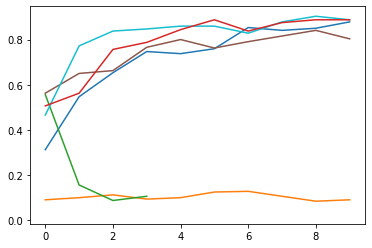

In [21]:
# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)

In [26]:
from hyperopt import hp
from ray.tune.suggest.hyperopt import HyperOptSearch

space = {
    "lr": hp.loguniform("lr", 1e-10, 0.1),
    "momentum": hp.uniform("momentum", 0.1, 0.9),
}

hyperopt_search = HyperOptSearch(space, metric="mean_accuracy", mode="max")

analysis = tune.run(train_mnist, num_samples=10, search_alg=hyperopt_search)

# To enable GPUs, use this instead:
# analysis = tune.run(
#     train_mnist, config=search_space, resources_per_trial={'gpu': 1})


Trial name,status,loc,lr,momentum
train_mnist_71abf396,PENDING,,1.09208,0.166771


(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(


(pid=15534) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=15534) Failed to download (trying next):
(pid=15534) HTTP Error 503: Service Unavailable
(pid=15534) 
(pid=15534) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz


(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(


(pid=15534) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz


 22%|██▏       | 2158592/9912422 [00:00<00:05, 1304721.98it/s]


(pid=15729) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=15729) Failed to download (trying next):
(pid=15729) HTTP Error 503: Service Unavailable
(pid=15729) 
(pid=15729) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz


 44%|████▍     | 4337664/9912422 [00:00<00:03, 1805513.04it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
 86%|████████▋ | 8562688/9912422 [00:00<00:00, 3225074.11it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
9913344it [00:00, 11691854.48it/s]                            


(pid=15534) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15729) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz


(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
 27%|██▋       | 2700288/9912422 [00:00<00:03, 2022011.48it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
 38%|███▊      | 3779584/9912422 [00:00<00:02, 2667591.13it/s]


(pid=15753) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=15534) 
(pid=15534) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=15753) Failed to download (trying next):
(pid=15753) HTTP Error 503: Service Unavailable
(pid=15753) 
(pid=15753) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=15534) Failed to download (trying next):
(pid=15534) HTTP Error 503: Service Unavailable
(pid=15534) 
(pid=15534) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz


 49%|████▉     | 4904960/9912422 [00:00<00:01, 3459403.14it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
 58%|█████▊    | 5747712/9912422 [00:00<00:00, 4199431.25it/s]


(pid=15534) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=15753) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz


 81%|████████  | 8051712/9912422 [00:00<00:00, 5924021.84it/s]


(pid=15534) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15534) 
(pid=15534) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=15729) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15534) Failed to download (trying next):
(pid=15534) HTTP Error 503: Service Unavailable
(pid=15534) 
(pid=15534) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]
9913344it [00:01, 9059671.20it/s]                             
29696it [00:00, 664043.91it/s]           
  9%|▉         | 886784/9912422 [00:00<00:07, 1212785.63it/s]


(pid=15534) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=15755) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=15755) Failed to download (trying next):
(pid=15755) HTTP Error 503: Service Unavailable
(pid=15755) 
(pid=15755) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz


 33%|███▎      | 3255296/9912422 [00:00<00:02, 2730873.11it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
 43%|████▎     | 4219904/9912422 [00:00<00:01, 3479072.93it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
 73%|███████▎  | 7284736/9912422 [00:01<00:00, 5431486.41it/s]


(pid=15755) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz


 24%|██▍       | 402432/1648877 [00:00<00:03, 361123.08it/s]
9913344it [00:01, 7404084.86it/s]                             
 45%|████▌     | 742400/1648877 [00:00<00:01, 493427.30it/s]


Trial name,status,loc,lr,momentum
train_mnist_71abf396,RUNNING,,1.09208,0.166771
train_mnist_71abf397,RUNNING,,1.06363,0.376857
train_mnist_71abf398,RUNNING,,1.01239,0.149677
train_mnist_71abf399,RUNNING,,1.06761,0.250371
train_mnist_71abf39a,RUNNING,,1.0686,0.144051
train_mnist_73012b26,RUNNING,,1.07137,0.192747
train_mnist_73012b27,RUNNING,,1.09214,0.261777
train_mnist_73012b28,RUNNING,,1.00548,0.483111
train_mnist_73d4ab04,PENDING,,1.04986,0.617687


  0%|          | 0/9912422 [00:00<?, ?it/s]
1649664it [00:00, 2165299.32it/s]                            
  2%|▏         | 199680/9912422 [00:00<00:06, 1469196.89it/s]


(pid=15753) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15534) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 40%|████      | 3972096/9912422 [00:00<00:01, 4106322.20it/s]


(pid=15793) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=15534) 
(pid=15534) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=15793) Failed to download (trying next):
(pid=15793) HTTP Error 503: Service Unavailable
(pid=15793) 
(pid=15793) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=15534) Failed to download (trying next):
(pid=15534) HTTP Error 503: Service Unavailable
(pid=15534) 
(pid=15534) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz


 77%|███████▋  | 7658496/9912422 [00:00<00:00, 6717323.71it/s]
9913344it [00:00, 10185381.30it/s]                            


(pid=15534) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=15755) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15793) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=15805) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=15729) 
(pid=15729) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=15805) Failed to download (trying next):
(pid=15805) HTTP Error 503: Service Unavailable
(pid=15805) 
(pid=15805) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=15729) Failed to download (trying next):
(pid=15729) HTTP Error 503: Service Unavailable
(pid=15729) 
(pid=15729) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=15534) Extracting

  0%|          | 0/9912422 [00:00<?, ?it/s]
5120it [00:00, 1307289.00it/s]          
(pid=15534) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=15534)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
  1%|          | 87040/9912422 [00:00<00:13, 736600.00it/s]


(pid=15729) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=15807) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz


(pid=15534) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=15534)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 0/28881 [00:00<?, ?it/s]


(pid=15807) Failed to download (trying next):
(pid=15807) HTTP Error 503: Service Unavailable
(pid=15807) 
(pid=15807) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=15729) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15729) 
(pid=15729) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz


29696it [00:00, 564563.74it/s]           
  4%|▍         | 435200/9912422 [00:00<00:10, 901788.41it/s]


(pid=15729) Failed to download (trying next):
(pid=15729) HTTP Error 503: Service Unavailable
(pid=15729) 
(pid=15729) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=15807) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz


 28%|██▊       | 2813952/9912422 [00:00<00:03, 2056629.54it/s]


(pid=15753) 
(pid=15753) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=15753) Failed to download (trying next):
(pid=15753) HTTP Error 503: Service Unavailable
(pid=15753) 
(pid=15753) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz


 96%|█████████▌| 9476096/9912422 [00:01<00:00, 7378524.79it/s]
9913344it [00:01, 8024477.88it/s]                             
 46%|████▌     | 4532224/9912422 [00:00<00:01, 3224367.40it/s]


(pid=15729) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=15793) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15753) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
Result for train_mnist_71abf396:
  date: 2021-06-22_16-33-19
  done: false
  experiment_id: da1b15ec361544e6af5851dc8e80b1a4
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.165625
  node_ip: 192.168.1.106
  pid: 15534
  time_since_restore: 7.245242595672607
  time_this_iter_s: 7.245242595672607
  time_total_s: 7.245242595672607
  timestamp: 1624397599
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 71abf396
  
(pid=15755) 
(pid=15755) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz


 90%|█████████ | 8925184/9912422 [00:01<00:00, 6541971.33it/s]


(pid=15755) Failed to download (trying next):
(pid=15755) HTTP Error 503: Service Unavailable
(pid=15755) 
(pid=15755) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz


 21%|██        | 350208/1648877 [00:00<00:01, 867668.86it/s]
29696it [00:00, 522499.91it/s]           
9913344it [00:01, 6903942.14it/s]                             
 43%|████▎     | 715776/1648877 [00:00<00:00, 1123170.98it/s]


(pid=15753) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15753) 
(pid=15753) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=15755) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=15866) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=15753) Failed to download (trying next):
(pid=15753) HTTP Error 503: Service Unavailable
(pid=15753) 
(pid=15753) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=15805) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15866) Failed to download (trying next):
(pid=15866) HTTP Error 503: Service Unavailable
(pid=15866) 
(pid=15866) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz


  0%|          | 0/9912422 [00:00<?, ?it/s]
1649664it [00:00, 2933698.44it/s]                             
29696it [00:00, 629353.29it/s]           
  1%|          | 87040/9912422 [00:00<00:14, 697982.79it/s]


(pid=15755) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15755) 
(pid=15755) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=15729) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15753) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=15866) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=15755) Failed to download (trying next):
(pid=15755) HTTP Error 503: Service Unavailable
(pid=15755) 
(pid=15755) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


  0%|          | 0/1648877 [00:00<?, ?it/s]


(pid=15729) 
(pid=15729) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=15729) Failed to download (trying next):
(pid=15729) HTTP Error 503: Service Unavailable
(pid=15729) 
(pid=15729) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz


 81%|████████  | 8048640/9912422 [00:00<00:00, 3298408.93it/s]


(pid=15755) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


 35%|███▍      | 575488/1648877 [00:00<00:01, 687436.79it/s]
9913344it [00:00, 12664896.89it/s]                            
  0%|          | 0/1648877 [00:00<?, ?it/s]


(pid=15807) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15729) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=15793) 
(pid=15793) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz


 82%|████████▏ | 1357824/1648877 [00:00<00:00, 1303066.40it/s]


(pid=15793) Failed to download (trying next):
(pid=15793) HTTP Error 503: Service Unavailable
(pid=15793) 
(pid=15793) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=15753) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 11%|█         | 174080/1648877 [00:00<00:04, 347537.70it/s]
1649664it [00:00, 1873157.37it/s]                             
 21%|██        | 348160/1648877 [00:00<00:02, 436384.73it/s]


(pid=15729) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15729) 
(pid=15793) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=15805) 
(pid=15805) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz


 31%|███       | 504832/1648877 [00:00<00:02, 556456.23it/s]
5120it [00:00, 1097727.16it/s]          
 77%|███████▋  | 7602176/9912422 [00:00<00:01, 2309687.54it/s]
(pid=15729) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_71abf396,RUNNING,192.168.1.106:15534,1.09208,0.166771,0.09375,2,8.39725
train_mnist_71abf397,RUNNING,,1.06363,0.376857,,,
train_mnist_71abf398,RUNNING,,1.01239,0.149677,,,
train_mnist_71abf399,RUNNING,,1.06761,0.250371,,,
train_mnist_71abf39a,RUNNING,,1.0686,0.144051,,,
train_mnist_73012b26,RUNNING,,1.07137,0.192747,,,
train_mnist_73012b27,RUNNING,,1.09214,0.261777,,,
train_mnist_73012b28,RUNNING,,1.00548,0.483111,,,
train_mnist_73d4ab04,PENDING,,1.04986,0.617687,,,



(pid=15729)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
 41%|████      | 678912/1648877 [00:00<00:01, 686547.81it/s]
(pid=15729) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=15729)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
 92%|█████████▏| 9076736/9912422 [00:01<00:00, 3077187.47it/s]


(pid=15753) 
(pid=15753) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


 52%|█████▏    | 851968/1648877 [00:00<00:00, 832180.28it/s]
9913344it [00:01, 8966240.70it/s]                             
  0%|          | 0/28881 [00:00<?, ?it/s]


(pid=15866) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15753) Failed to download (trying next):
(pid=15753) HTTP Error 503: Service Unavailable
(pid=15753) 
(pid=15753) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=15805) Failed to download (trying next):
(pid=15805) HTTP Error 503: Service Unavailable
(pid=15805) 
(pid=15805) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz


29696it [00:00, 648499.47it/s]           


(pid=15793) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15793) 
(pid=15793) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=15753) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=15805) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=15807) 
(pid=15807) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Result for train_mnist_71abf397:
  date: 2021-06-22_16-33-22
  done: false
  experiment_id: 1d80906909414938bd5c0d2f98373d3e
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.0875
  node_ip: 192.168.1.106
  pid: 15729
  time_since_restore: 9.006824970245361
  time_this_iter_s: 9.006824970245361
  time_total_s: 9.006824970245361
  timestamp: 1624397602
  timesteps_since_restore: 0
  traini

 80%|████████  | 1323008/1648877 [00:01<00:00, 1193228.95it/s]


(pid=15755) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


1649664it [00:01, 1387281.70it/s]                             


(pid=15755) 
(pid=15755) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=15753) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15753) 
(pid=15866) 
(pid=15866) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=15793) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=15805) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15805) 
(pid=15805) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=15755) Failed to download (trying next):
(pid=15755) HTTP Error 503: Service Unavailable
(pid=15755) 
(pid=15755) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz


5120it [00:00, 3281607.04it/s]          
  0%|          | 0/28881 [00:00<?, ?it/s]
(pid=15753) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=15753)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
(pid=15753) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are rel

(pid=15805) Failed to download (trying next):
(pid=15805) HTTP Error 503: Service Unavailable
(pid=15805) 
(pid=15805) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=15866) Failed to download (trying next):
(pid=15866) HTTP Error 503: Service Unavailable
(pid=15866) 
(pid=15866) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=15755) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=15807) Failed to download (trying next):
(pid=15807) HTTP Error 503: Service Unavailable
(pid=15807) 
(pid=15807) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=15866) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


  5%|▌         | 87040/1648877 [00:00<00:02, 669964.23it/s]


(pid=15805) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
Result for train_mnist_71abf398:
  date: 2021-06-22_16-33-22
  done: false
  experiment_id: 303fee2bd3874ed7b430abe748593453
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.025
  node_ip: 192.168.1.106
  pid: 15753
  time_since_restore: 8.491253852844238
  time_this_iter_s: 8.491253852844238
  time_total_s: 8.491253852844238
  timestamp: 1624397602
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 71abf398
  
(pid=15755) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15755) 
(pid=15807) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


5120it [00:00, 2951867.56it/s]          
(pid=15755) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=15755)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
  8%|▊         | 139264/1648877 [00:00<00:02, 581898.66it/s]
(pid=15755) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important

(pid=15866) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15866) 
(pid=15866) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=15807) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15807) 
(pid=15807) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=15866) Failed to download (trying next):
(pid=15866) HTTP Error 503: Service Unavailable
(pid=15866) 
(pid=15866) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


29696it [00:00, 607166.09it/s]           
1649664it [00:00, 2725335.03it/s]                             
  0%|          | 0/1648877 [00:00<?, ?it/s]


(pid=15793) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15793) 
(pid=15793) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=15807) Failed to download (trying next):
(pid=15807) HTTP Error 503: Service Unavailable
(pid=15807) 
(pid=15807) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
Result for train_mnist_71abf399:
  date: 2021-06-22_16-33-23
  done: false
  experiment_id: 1b8a696e184e4fc79a367689845945af
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.090625
  node_ip: 192.168.1.106
  pid: 15755
  time_since_restore: 7.787755966186523
  time_this_iter_s: 7.787755966186523
  time_total_s: 7.787755966186523
  timestamp: 1624397603
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 71abf399
  
(pid=15866) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(

 30%|██▉       | 487424/1648877 [00:00<00:01, 731390.91it/s]


(pid=15807) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=15793) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=15805) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 96%|█████████▌| 1584128/1648877 [00:00<00:00, 1304484.15it/s]
1649664it [00:00, 3219880.86it/s]                             
  4%|▍         | 69632/1648877 [00:00<00:03, 453531.22it/s]


(pid=15805) 
(pid=15805) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=15793) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15793) 
(pid=15805) Failed to download (trying next):
(pid=15805) HTTP Error 503: Service Unavailable
(pid=15805) 
(pid=15805) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz


 21%|██        | 348160/1648877 [00:00<00:02, 605369.00it/s]
5120it [00:00, 3247857.91it/s]          
  4%|▍         | 69632/1648877 [00:00<00:02, 545899.32it/s]
(pid=15793) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=15793)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
 39%|███▉      | 644096/1648877 [00:00<00:01, 782470.11it/s]
(pid=15793) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and a

(pid=15805) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=15807) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15866) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15866) 
(pid=15866) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=15807) 
(pid=15807) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=15866) Failed to download (trying next):
(pid=15866) HTTP Error 503: Service Unavailable
(pid=15866) 
(pid=15866) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=15805) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15805) 
(pid=15807) Failed to download (trying next):
(pid=15807) HTTP Error 503: Service Unavailable
(pid=15807) 
(pid=15807) Downloading https://ossci-datasets.s3.amazona

5120it [00:00, 659081.01it/s]           
(pid=15805) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=15805)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(pid=15866) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=15807) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz


(pid=15805) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=15805)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(pid=15866) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15866) 
(pid=15807) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15807) 


5120it [00:00, 1260260.36it/s]          
5120it [00:00, 276684.10it/s]           
(pid=15866) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=15866)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
(pid=15807) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-wr

Result for train_mnist_71abf396:
  date: 2021-06-22_16-33-25
  done: false
  experiment_id: da1b15ec361544e6af5851dc8e80b1a4
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.1
  node_ip: 192.168.1.106
  pid: 15534
  time_since_restore: 13.248454809188843
  time_this_iter_s: 1.4119195938110352
  time_total_s: 13.248454809188843
  timestamp: 1624397605
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 71abf396
  
Result for train_mnist_71abf396:
  date: 2021-06-22_16-33-25
  done: true
  experiment_id: da1b15ec361544e6af5851dc8e80b1a4
  experiment_tag: 1_lr=1.0921,momentum=0.16677
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.1
  node_ip: 192.168.1.106
  pid: 15534
  time_since_restore: 13.248454809188843
  time_this_iter_s: 1.4119195938110352
  time_total_s: 13.248454809188843
  timestamp: 1624397605
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 71abf396
  
Result for train_mnist_73012b26:
 

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_71abf397,RUNNING,192.168.1.106:15729,1.06363,0.376857,0.13125,8,13.0978
train_mnist_71abf398,RUNNING,192.168.1.106:15753,1.01239,0.149677,0.115625,6,12.4023
train_mnist_71abf399,RUNNING,192.168.1.106:15755,1.06761,0.250371,0.1,4,10.4452
train_mnist_71abf39a,RUNNING,192.168.1.106:15793,1.0686,0.144051,0.078125,2,9.19134
train_mnist_73012b26,RUNNING,192.168.1.106:15805,1.07137,0.192747,0.1,1,8.60695
train_mnist_73012b27,RUNNING,192.168.1.106:15807,1.09214,0.261777,0.090625,1,8.47135
train_mnist_73012b28,RUNNING,,1.00548,0.483111,,,
train_mnist_73d4ab04,RUNNING,,1.04986,0.617687,,,
train_mnist_7a2a5cd8,PENDING,,1.01336,0.415122,,,
train_mnist_71abf396,TERMINATED,,1.09208,0.166771,0.1,10,13.2485


Result for train_mnist_73012b28:
  date: 2021-06-22_16-33-27
  done: false
  experiment_id: 535c34dc0c134937b8b37dcaa6e7f123
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.140625
  node_ip: 192.168.1.106
  pid: 15866
  time_since_restore: 7.11986231803894
  time_this_iter_s: 7.11986231803894
  time_total_s: 7.11986231803894
  timestamp: 1624397607
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 73012b28
  
Result for train_mnist_71abf397:
  date: 2021-06-22_16-33-28
  done: false
  experiment_id: 1d80906909414938bd5c0d2f98373d3e
  hostname: therealchainman
  iterations_since_restore: 9
  mean_accuracy: 0.109375
  node_ip: 192.168.1.106
  pid: 15729
  time_since_restore: 14.91342282295227
  time_this_iter_s: 1.8156371116638184
  time_total_s: 14.91342282295227
  timestamp: 1624397608
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 71abf397
  
Result for train_mnist_71abf398:
  date: 2021-06-22_16-33-28
  done: false
  exper

(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(


Result for train_mnist_71abf399:
  date: 2021-06-22_16-33-28
  done: false
  experiment_id: 1b8a696e184e4fc79a367689845945af
  hostname: therealchainman
  iterations_since_restore: 6
  mean_accuracy: 0.078125
  node_ip: 192.168.1.106
  pid: 15755
  time_since_restore: 13.306444644927979
  time_this_iter_s: 1.5223569869995117
  time_total_s: 13.306444644927979
  timestamp: 1624397608
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 71abf399
  
Result for train_mnist_71abf397:
  date: 2021-06-22_16-33-29
  done: true
  experiment_id: 1d80906909414938bd5c0d2f98373d3e
  experiment_tag: 2_lr=1.0636,momentum=0.37686
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.115625
  node_ip: 192.168.1.106
  pid: 15729
  time_since_restore: 16.443101167678833
  time_this_iter_s: 1.5296783447265625
  time_total_s: 16.443101167678833
  timestamp: 1624397609
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 71abf397
  
Result for train_mnist_71a

(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(


Result for train_mnist_73012b26:
  date: 2021-06-22_16-33-31
  done: false
  experiment_id: 2a4483be3abf49d49131e350bbd7884c
  hostname: therealchainman
  iterations_since_restore: 5
  mean_accuracy: 0.1
  node_ip: 192.168.1.106
  pid: 15805
  time_since_restore: 14.100631475448608
  time_this_iter_s: 1.2674229145050049
  time_total_s: 14.100631475448608
  timestamp: 1624397611
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 73012b26
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_71abf398,RUNNING,192.168.1.106:15753,1.01239,0.149677,0.09375,9,16.7504
train_mnist_71abf399,RUNNING,192.168.1.106:15755,1.06761,0.250371,0.1,7,14.6479
train_mnist_71abf39a,RUNNING,192.168.1.106:15793,1.0686,0.144051,0.1125,5,14.0867
train_mnist_73012b26,RUNNING,192.168.1.106:15805,1.07137,0.192747,0.1,5,14.1006
train_mnist_73012b27,RUNNING,192.168.1.106:15807,1.09214,0.261777,0.121875,3,11.8747
train_mnist_73012b28,RUNNING,192.168.1.106:15866,1.00548,0.483111,0.109375,3,10.7155
train_mnist_73d4ab04,RUNNING,,1.04986,0.617687,,,
train_mnist_7a2a5cd8,RUNNING,,1.01336,0.415122,,,
train_mnist_71abf396,TERMINATED,,1.09208,0.166771,0.1,10,13.2485
train_mnist_71abf397,TERMINATED,,1.06363,0.376857,0.115625,10,16.4431


Result for train_mnist_73012b27:
  date: 2021-06-22_16-33-31
  done: false
  experiment_id: f47bd0592cac4f8baf979506dc643404
  hostname: therealchainman
  iterations_since_restore: 4
  mean_accuracy: 0.06875
  node_ip: 192.168.1.106
  pid: 15807
  time_since_restore: 13.625557661056519
  time_this_iter_s: 1.7509076595306396
  time_total_s: 13.625557661056519
  timestamp: 1624397611
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 73012b27
  
Result for train_mnist_73012b28:
  date: 2021-06-22_16-33-32
  done: false
  experiment_id: 535c34dc0c134937b8b37dcaa6e7f123
  hostname: therealchainman
  iterations_since_restore: 4
  mean_accuracy: 0.128125
  node_ip: 192.168.1.106
  pid: 15866
  time_since_restore: 12.177461385726929
  time_this_iter_s: 1.462005853652954
  time_total_s: 12.177461385726929
  timestamp: 1624397612
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 73012b28
  
Result for train_mnist_71abf398:
  date: 2021-06-22_16-33-32
  done: true
  

  1%|          | 68608/9912422 [00:00<00:19, 514769.44it/s]


(pid=16011) Failed to download (trying next):
(pid=16011) HTTP Error 503: Service Unavailable
(pid=16011) 
(pid=16011) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz


 27%|██▋       | 2635776/9912422 [00:00<00:04, 1715259.00it/s]


(pid=16011) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz


  3%|▎         | 269312/9912422 [00:00<00:14, 686330.61it/s]


Result for train_mnist_73012b26:
  date: 2021-06-22_16-33-34
  done: true
  experiment_id: 2a4483be3abf49d49131e350bbd7884c
  experiment_tag: 6_lr=1.0714,momentum=0.19275
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.10625
  node_ip: 192.168.1.106
  pid: 15805
  time_since_restore: 16.674837589263916
  time_this_iter_s: 0.9560546875
  time_total_s: 16.674837589263916
  timestamp: 1624397614
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 73012b26
  


 11%|█         | 1052672/9912422 [00:00<00:07, 1163848.75it/s]


Result for train_mnist_71abf39a:
  date: 2021-06-22_16-33-34
  done: true
  experiment_id: f38dc07ad2f145219359edf9f1498cb4
  experiment_tag: 5_lr=1.0686,momentum=0.14405
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.128125
  node_ip: 192.168.1.106
  pid: 15793
  time_since_restore: 17.540234088897705
  time_this_iter_s: 1.138627052307129
  time_total_s: 17.540234088897705
  timestamp: 1624397614
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 71abf39a
  


 36%|███▌      | 3564544/9912422 [00:00<00:02, 3024706.62it/s]
9913344it [00:01, 5908784.44it/s]                             
 47%|████▋     | 4670464/9912422 [00:00<00:01, 3867391.44it/s]


(pid=15987) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
Result for train_mnist_73012b28:


 70%|███████   | 6956032/9912422 [00:01<00:00, 5519173.00it/s]


  date: 2021-06-22_16-33-35
  done: true
  experiment_id: 535c34dc0c134937b8b37dcaa6e7f123
  experiment_tag: 8_lr=1.0055,momentum=0.48311
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.06875
  node_ip: 192.168.1.106
  pid: 15866
  time_since_restore: 15.45313310623169
  time_this_iter_s: 1.0120062828063965
  time_total_s: 15.45313310623169
  timestamp: 1624397615
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 73012b28
  


 82%|████████▏ | 8095744/9912422 [00:01<00:00, 6529388.44it/s]
9913344it [00:01, 6668463.72it/s]                             


(pid=16011) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
Result for train_mnist_73012b27:
  date: 2021-06-22_16-33-35
  done: true
  experiment_id: f47bd0592cac4f8baf979506dc643404
  experiment_tag: 7_lr=1.0921,momentum=0.26178
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.084375
  node_ip: 192.168.1.106
  pid: 15807
  time_since_restore: 17.545503616333008
  time_this_iter_s: 1.0389115810394287
  time_total_s: 17.545503616333008
  timestamp: 1624397615
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 73012b27
  
(pid=15987) 
(pid=15987) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=15987) Failed to download (trying next):
(pid=15987) HTTP Error 503: Service Unavailable
(pid=15987) 
(pid=15987) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=15987) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte

29696it [00:00, 660606.49it/s]           


(pid=16011) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16011) 
(pid=16011) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=15987) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=16011) Failed to download (trying next):
(pid=16011) HTTP Error 503: Service Unavailable
(pid=16011) 
(pid=16011) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


29696it [00:00, 696303.38it/s]           
 26%|██▌       | 425984/1648877 [00:00<00:01, 837832.25it/s]


(pid=16011) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


  0%|          | 0/1648877 [00:00<?, ?it/s]
1649664it [00:00, 3476677.07it/s]                             
  5%|▌         | 87040/1648877 [00:00<00:02, 656444.14it/s]


(pid=15987) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15987) 
(pid=15987) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


 64%|██████▍   | 1060864/1648877 [00:00<00:00, 1337367.09it/s]


(pid=15987) Failed to download (trying next):
(pid=15987) HTTP Error 503: Service Unavailable
(pid=15987) 
(pid=15987) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=16011) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 88%|████████▊ | 1444864/1648877 [00:00<00:00, 1657858.93it/s]
1649664it [00:00, 2623052.31it/s]                             


(pid=15987) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=16011) 
(pid=16011) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=15987) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=15987) 


  0%|          | 0/4542 [00:00<?, ?it/s]
5120it [00:00, 1021006.82it/s]          
(pid=15987) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=15987)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(pid=16011) Failed to download (trying next):
(pid=16011) HTTP Error 503: Service Unavailable
(pid=16011) 
(pid=16011) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz


(pid=15987) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=15987)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(pid=16011) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=16011) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16011) 


5120it [00:00, 2387950.24it/s]          
(pid=16011) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=16011)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
(pid=16011) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at 

Result for train_mnist_73d4ab04:
  date: 2021-06-22_16-33-40
  done: false
  experiment_id: 9c3c83f7b0ab4f419d16fec2ed71077e
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.084375
  node_ip: 192.168.1.106
  pid: 15987
  time_since_restore: 7.305110931396484
  time_this_iter_s: 7.305110931396484
  time_total_s: 7.305110931396484
  timestamp: 1624397620
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 73d4ab04
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_73d4ab04,RUNNING,192.168.1.106:15987,1.04986,0.617687,0.084375,1,7.30511
train_mnist_7a2a5cd8,RUNNING,,1.01336,0.415122,,,
train_mnist_71abf396,TERMINATED,,1.09208,0.166771,0.1,10,13.2485
train_mnist_71abf397,TERMINATED,,1.06363,0.376857,0.115625,10,16.4431
train_mnist_71abf398,TERMINATED,,1.01239,0.149677,0.075,10,17.8148
train_mnist_71abf399,TERMINATED,,1.06761,0.250371,0.09375,10,17.3146
train_mnist_71abf39a,TERMINATED,,1.0686,0.144051,0.128125,10,17.5402
train_mnist_73012b26,TERMINATED,,1.07137,0.192747,0.10625,10,16.6748
train_mnist_73012b27,TERMINATED,,1.09214,0.261777,0.084375,10,17.5455
train_mnist_73012b28,TERMINATED,,1.00548,0.483111,0.06875,10,15.4531


Result for train_mnist_7a2a5cd8:
  date: 2021-06-22_16-33-40
  done: false
  experiment_id: 02b763175b0d4c3bbdc67a70534d3338
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.1
  node_ip: 192.168.1.106
  pid: 16011
  time_since_restore: 7.154386520385742
  time_this_iter_s: 7.154386520385742
  time_total_s: 7.154386520385742
  timestamp: 1624397620
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7a2a5cd8
  
Result for train_mnist_73d4ab04:
  date: 2021-06-22_16-33-42
  done: true
  experiment_id: 9c3c83f7b0ab4f419d16fec2ed71077e
  experiment_tag: 9_lr=1.0499,momentum=0.61769
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.121875
  node_ip: 192.168.1.106
  pid: 15987
  time_since_restore: 9.354254245758057
  time_this_iter_s: 0.17636561393737793
  time_total_s: 9.354254245758057
  timestamp: 1624397622
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 73d4ab04
  
Result for train_mnist_7a2a5cd8:
  

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_71abf396,TERMINATED,,1.09208,0.166771,0.1,10,13.2485
train_mnist_71abf397,TERMINATED,,1.06363,0.376857,0.115625,10,16.4431
train_mnist_71abf398,TERMINATED,,1.01239,0.149677,0.075,10,17.8148
train_mnist_71abf399,TERMINATED,,1.06761,0.250371,0.09375,10,17.3146
train_mnist_71abf39a,TERMINATED,,1.0686,0.144051,0.128125,10,17.5402
train_mnist_73012b26,TERMINATED,,1.07137,0.192747,0.10625,10,16.6748
train_mnist_73012b27,TERMINATED,,1.09214,0.261777,0.084375,10,17.5455
train_mnist_73012b28,TERMINATED,,1.00548,0.483111,0.06875,10,15.4531
train_mnist_73d4ab04,TERMINATED,,1.04986,0.617687,0.121875,10,9.35425
train_mnist_7a2a5cd8,TERMINATED,,1.01336,0.415122,0.1125,10,8.87509


2021-06-22 16:33:42,514	INFO tune.py:549 -- Total run time: 31.00 seconds (30.88 seconds for the tuning loop).


## Testing speed with ray backend and without

In [ ]:
ray.shutdown()
times = []

In [ ]:
def train_mnist2():
    # Data Setup
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = DataLoader(
        datasets.MNIST("{cwd}/data", train=True, download=True, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    test_loader = DataLoader(
        datasets.MNIST(f"{cwd}/data", train=False, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ConvNet()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    for i in range(10):
        train(model, optimizer, train_loader)
        acc = test(model, test_loader)

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")

In [ ]:
start = time.time()
for _ in range(10):
    train_mnist2()
times.append(time.time()-start)

In [ ]:
ray.init()

In [28]:
import time
times = []
start = time.time()
analysis = tune.run(
    train_mnist,
    num_samples=20,
#     scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    config=search_space)
times.append(start-time.time())

Trial name,status,loc,lr,momentum
train_mnist_af561_00000,PENDING,,6.41811e-07,0.189627
train_mnist_af561_00001,PENDING,,2.92354e-09,0.501897
train_mnist_af561_00002,PENDING,,1.01225e-08,0.383448
train_mnist_af561_00003,PENDING,,1.55157e-06,0.778785
train_mnist_af561_00004,PENDING,,6.29387e-09,0.252046
train_mnist_af561_00005,PENDING,,2.83837e-05,0.635141
train_mnist_af561_00006,PENDING,,2.12237e-09,0.881509
train_mnist_af561_00007,PENDING,,3.41018e-08,0.485819
train_mnist_af561_00008,PENDING,,8.61318e-08,0.189483
train_mnist_af561_00009,PENDING,,0.00177473,0.293255


(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warning

(pid=16299) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=16305) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=16299) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=16304) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=16301) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=16306) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=16303) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=16302) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=16300) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=16299) Failed to download (trying next):
(pid=16299) HTTP Error 503: Service Unavailable
(pid=16299) 
(pid=16299) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx

 13%|█▎        | 1296384/9912422 [00:00<00:06, 1379075.33it/s]


Trial name,status,loc,lr,momentum
train_mnist_af561_00000,RUNNING,,6.41811e-07,0.189627
train_mnist_af561_00001,RUNNING,,2.92354e-09,0.501897
train_mnist_af561_00002,RUNNING,,1.01225e-08,0.383448
train_mnist_af561_00003,RUNNING,,1.55157e-06,0.778785
train_mnist_af561_00004,RUNNING,,6.29387e-09,0.252046
train_mnist_af561_00005,RUNNING,,2.83837e-05,0.635141
train_mnist_af561_00006,RUNNING,,2.12237e-09,0.881509
train_mnist_af561_00007,RUNNING,,3.41018e-08,0.485819
train_mnist_af561_00008,PENDING,,8.61318e-08,0.189483
train_mnist_af561_00009,PENDING,,0.00177473,0.293255


 71%|███████   | 7001088/9912422 [00:05<00:02, 1289218.66it/s]
9913344it [00:05, 1844666.76it/s]                             
9913344it [00:05, 1838795.46it/s]                             
 72%|███████▏  | 7171072/9912422 [00:05<00:01, 1380087.41it/s]


(pid=16305) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16302) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 67%|██████▋   | 6596608/9912422 [00:05<00:02, 1389990.90it/s]


Trial name,status,loc,lr,momentum
train_mnist_af561_00000,RUNNING,,6.41811e-07,0.189627
train_mnist_af561_00001,RUNNING,,2.92354e-09,0.501897
train_mnist_af561_00002,RUNNING,,1.01225e-08,0.383448
train_mnist_af561_00003,RUNNING,,1.55157e-06,0.778785
train_mnist_af561_00004,RUNNING,,6.29387e-09,0.252046
train_mnist_af561_00005,RUNNING,,2.83837e-05,0.635141
train_mnist_af561_00006,RUNNING,,2.12237e-09,0.881509
train_mnist_af561_00007,RUNNING,,3.41018e-08,0.485819
train_mnist_af561_00008,PENDING,,8.61318e-08,0.189483
train_mnist_af561_00009,PENDING,,0.00177473,0.293255


 26%|██▌       | 2597888/9912422 [00:06<00:15, 462963.57it/s]
9913344it [00:06, 1586567.78it/s]                             
 72%|███████▏  | 7136256/9912422 [00:06<00:01, 1784954.48it/s]


(pid=16305) 
(pid=16305) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=16302) 
(pid=16302) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=16299) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 77%|███████▋  | 7641088/9912422 [00:06<00:01, 1912217.16it/s]


(pid=16305) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=16302) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]
9913344it [00:06, 1489214.63it/s]                             
29696it [00:00, 1387773.41it/s]          
 96%|█████████▌| 9473024/9912422 [00:06<00:00, 2218297.35it/s]


(pid=16302) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16300) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16302) 
(pid=16302) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=16299) 
(pid=16299) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=16304) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16305) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16305) 
(pid=16305) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=16302) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


 84%|████████▍ | 8337408/9912422 [00:06<00:00, 2089534.24it/s]
9913344it [00:06, 1474851.14it/s]                             
 31%|███       | 3066880/9912422 [00:06<00:09, 685196.14it/s]
29696it [00:00, 145565.40it/s]                          
 93%|█████████▎| 9190400/9912422 [00:06<00:00, 2612257.88it/s]
9913344it [00:07, 1415215.77it/s]                             


(pid=16299) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=16305) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=16302) Failed to download (trying next):
(pid=16302) HTTP Error 503: Service Unavailable
(pid=16302) 
(pid=16302) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=16299) Failed to download (trying next):
(pid=16299) HTTP Error 503: Service Unavailable
(pid=16299) 
(pid=16299) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=16300) 
(pid=16300) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=16305) Failed to download (trying next):
(pid=16305) HTTP Error 503: Service Unavailable
(pid=16305) 
(pid=16305) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=16301) Extracting {c

 34%|███▎      | 3329024/9912422 [00:07<00:08, 806869.22it/s]
9913344it [00:07, 1398261.14it/s]                             
 36%|███▌      | 3554304/9912422 [00:07<00:06, 998514.04it/s]


(pid=16304) 
(pid=16304) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=16303) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16304) Failed to download (trying next):
(pid=16304) HTTP Error 503: Service Unavailable
(pid=16304) 
(pid=16304) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=16300) Failed to download (trying next):
(pid=16300) HTTP Error 503: Service Unavailable
(pid=16300) 
(pid=16300) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=16299) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=16302) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=16305) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/d

  0%|          | 0/28881 [00:00<?, ?it/s]


(pid=16300) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=16304) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=16301) 
(pid=16301) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=16303) 
(pid=16303) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz


29696it [00:00, 620554.88it/s]           
  3%|▎         | 41984/1648877 [00:00<00:03, 403622.55it/s]
29696it [00:00, 498732.89it/s]           
 10%|▉         | 164864/1648877 [00:00<00:02, 505101.80it/s]
29696it [00:00, 594391.06it/s]           


(pid=16301) Failed to download (trying next):
(pid=16301) HTTP Error 503: Service Unavailable
(pid=16301) 
(pid=16301) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=16303) Failed to download (trying next):
(pid=16303) HTTP Error 503: Service Unavailable
(pid=16303) 
(pid=16303) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=16300) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16300) 
(pid=16300) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=16299) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16299) 
(pid=16299) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=16304) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16304) 
(pid=16304) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz


 64%|██████▍   | 1060864/1648877 [00:00<00:00, 1237967.13it/s]


(pid=16304) Failed to download (trying next):
(pid=16304) HTTP Error 503: Service Unavailable
(pid=16304) 
(pid=16304) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=16301) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=16300) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=16299) Failed to download (trying next):
(pid=16299) HTTP Error 503: Service Unavailable
(pid=16299) 
(pid=16299) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=16303) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=16300) Failed to download (trying next):
(pid=16300) HTTP Error 503: Service Unavailable
(pid=16300) 
(pid=16300) Downloading https://ossci-datasets.s3.amazonaw

 51%|█████▏    | 5087232/9912422 [00:08<00:03, 1541500.12it/s]
1649664it [00:00, 2294574.26it/s]                             
 78%|███████▊  | 1278976/1648877 [00:00<00:00, 1258233.74it/s]
29696it [00:00, 464948.23it/s]           
29696it [00:00, 547670.89it/s]           
 53%|█████▎    | 5261312/9912422 [00:08<00:03, 1490878.84it/s]


(pid=16304) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=16299) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=16300) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=16301) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16301) 
(pid=16301) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=16303) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16303) 
(pid=16303) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz


1649664it [00:00, 2161903.72it/s]                             
  5%|▌         | 87040/1648877 [00:00<00:02, 642952.38it/s]


(pid=16305) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16301) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=16303) Failed to download (trying next):
(pid=16303) HTTP Error 503: Service Unavailable
(pid=16303) 
(pid=16303) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=16302) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16302) 
(pid=16302) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=16305) 
(pid=16305) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=16301) Failed to download (trying next):
(pid=16301) HTTP Error 503: Service Unavailable
(pid=16301) 
(pid=16301) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=16303) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images

 31%|███       | 513024/1648877 [00:00<00:01, 905252.40it/s]
1649664it [00:00, 3530942.38it/s]                             
  0%|          | 0/1648877 [00:00<?, ?it/s]


(pid=16304) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16301) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=16304) 
(pid=16304) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=16302) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=16305) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=16299) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16304) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz


1649664it [00:00, 2674083.99it/s]                             
 11%|█         | 174080/1648877 [00:00<00:03, 387785.37it/s]
1649664it [00:00, 2206558.04it/s]                             
5120it [00:00, 1108836.50it/s]          
 67%|██████▋   | 6601728/9912422 [00:09<00:02, 1445649.91it/s]
5120it [00:00, 12859183.52it/s]         
(pid=16304) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=16304)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
(pid=16302) /home/therea

(pid=16299) 
(pid=16299) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=16304) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16304) 
(pid=16302) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16302) 
(pid=16300) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16299) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=16305) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16305) 
(pid=16300) 
(pid=16300) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


(pid=16302) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=16302)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
5120it [00:00, 5702293.28it/s]          
 41%|████      | 678912/1648877 [00:00<00:01, 535494.61it/s]
(pid=16304) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=16304)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode

(pid=16299) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16299) 
(pid=16300) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Result for train_mnist_af561_00005:
  date: 2021-06-22_16-42-18
  done: false
  experiment_id: b368527f0fe245bfa332c2a99e5812f6
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.075
  node_ip: 192.168.1.106
  pid: 16302
  time_since_restore: 10.901713371276855
  time_this_iter_s: 10.901713371276855
  time_total_s: 10.901713371276855
  timestamp: 1624398138
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: af561_00005
  
Result for train_mnist_af561_00004:
  date: 2021-06-22_16-42-18
  done: false
  experiment_id: 543c49bd46984f0f83ceb86affc3d6f1
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.128125
  node_ip: 192.168.1.106
  pid: 16304
  time_since_restore: 10.987253189086914
  t

5120it [00:00, 14202934.18it/s]         
 29%|██▉       | 478208/1648877 [00:00<00:01, 854728.83it/s]
1649664it [00:00, 2968979.69it/s]                            
(pid=16300) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=16300)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
 49%|████▉     | 808960/1648877 [00:00<00:00, 1098871.20it/s]
(pid=16300) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors an

Result for train_mnist_af561_00002:
  date: 2021-06-22_16-42-18
  done: false
  experiment_id: bd3664c68ff04387acbc03fe2d188f74
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.103125
  node_ip: 192.168.1.106
  pid: 16305
  time_since_restore: 11.171081304550171
  time_this_iter_s: 11.171081304550171
  time_total_s: 11.171081304550171
  timestamp: 1624398138
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: af561_00002
  
(pid=16303) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Result for train_mnist_af561_00003:
  date: 2021-06-22_16-42-18
  done: false
  experiment_id: 4a7f2ed662d0436bb28bc72f7531431a
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.096875
  node_ip: 192.168.1.106
  pid: 16299
  time_since_restore: 11.443877935409546
  time_this_iter_s: 11.443877935409546
  time_total_s: 11.443877935409546
  timestamp: 1624398138
  timeste

 77%|███████▋  | 7681024/9912422 [00:09<00:01, 1727223.65it/s]
1649664it [00:00, 2428622.73it/s]                             
5120it [00:00, 23165950.90it/s]         


(pid=16301) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16303) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16303) 
(pid=16301) 
(pid=16301) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


 80%|████████  | 7959552/9912422 [00:09<00:01, 1886168.59it/s]
(pid=16303) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=16303)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
 83%|████████▎ | 8220672/9912422 [00:10<00:00, 2000369.51it/s]
(pid=16303) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use the

Result for train_mnist_af561_00007:
  date: 2021-06-22_16-42-18
  done: false
  experiment_id: 44d4dccd5da441a1a79b3d5e6f63d5ab
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.15
  node_ip: 192.168.1.106
  pid: 16300
  time_since_restore: 11.472389698028564
  time_this_iter_s: 11.472389698028564
  time_total_s: 11.472389698028564
  timestamp: 1624398138
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: af561_00007
  
(pid=16301) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=16301) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16301) 


5120it [00:00, 23066419.42it/s]         
 88%|████████▊ | 8742912/9912422 [00:10<00:00, 2130334.10it/s]
(pid=16301) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=16301)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
(pid=16301) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything importa

Result for train_mnist_af561_00001:
  date: 2021-06-22_16-42-19
  done: false
  experiment_id: efc0481c25bb4f03ad15a94907336a14
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.1125
  node_ip: 192.168.1.106
  pid: 16303
  time_since_restore: 11.848498582839966
  time_this_iter_s: 11.848498582839966
  time_total_s: 11.848498582839966
  timestamp: 1624398139
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: af561_00001
  


9913344it [00:10, 929054.20it/s]                              


(pid=16306) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
Result for train_mnist_af561_00000:
  date: 2021-06-22_16-42-19
  done: false
  experiment_id: 19c4c717727640feae4cf750356b0d7c
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.103125
  node_ip: 192.168.1.106
  pid: 16301
  time_since_restore: 12.271330118179321
  time_this_iter_s: 12.271330118179321
  time_total_s: 12.271330118179321
  timestamp: 1624398139
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: af561_00000
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_af561_00000,RUNNING,192.168.1.106:16301,6.41811e-07,0.189627,0.103125,1,12.2713
train_mnist_af561_00001,RUNNING,192.168.1.106:16303,2.92354e-09,0.501897,0.121875,2,12.3914
train_mnist_af561_00002,RUNNING,192.168.1.106:16305,1.01225e-08,0.383448,0.096875,3,12.1652
train_mnist_af561_00003,RUNNING,192.168.1.106:16299,1.55157e-06,0.778785,0.1,3,12.4464
train_mnist_af561_00004,RUNNING,192.168.1.106:16304,6.29387e-09,0.252046,0.1375,4,12.4604
train_mnist_af561_00005,RUNNING,192.168.1.106:16302,2.83837e-05,0.635141,0.075,4,12.4742
train_mnist_af561_00006,RUNNING,,2.12237e-09,0.881509,,,
train_mnist_af561_00007,RUNNING,192.168.1.106:16300,3.41018e-08,0.485819,0.159375,3,12.589
train_mnist_af561_00008,PENDING,,8.61318e-08,0.189483,,,
train_mnist_af561_00009,PENDING,,0.00177473,0.293255,,,


(pid=16306) 
(pid=16306) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=16306) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]
29696it [00:00, 889627.32it/s]           


(pid=16306) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16306) 
(pid=16306) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=16306) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


  6%|▌         | 91136/1648877 [00:02<00:52, 29523.60it/s]


Result for train_mnist_af561_00002:
  date: 2021-06-22_16-42-23
  done: false
  experiment_id: bd3664c68ff04387acbc03fe2d188f74
  hostname: therealchainman
  iterations_since_restore: 7
  mean_accuracy: 0.109375
  node_ip: 192.168.1.106
  pid: 16305
  time_since_restore: 16.56432819366455
  time_this_iter_s: 1.349928617477417
  time_total_s: 16.56432819366455
  timestamp: 1624398143
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: af561_00002
  
Result for train_mnist_af561_00004:
  date: 2021-06-22_16-42-24
  done: false
  experiment_id: 543c49bd46984f0f83ceb86affc3d6f1
  hostname: therealchainman
  iterations_since_restore: 8
  mean_accuracy: 0.109375
  node_ip: 192.168.1.106
  pid: 16304
  time_since_restore: 16.702067852020264
  time_this_iter_s: 1.780184030532837
  time_total_s: 16.702067852020264
  timestamp: 1624398144
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: af561_00004
  


  7%|▋         | 115712/1648877 [00:03<00:42, 35676.58it/s]


Result for train_mnist_af561_00005:
  date: 2021-06-22_16-42-24
  done: false
  experiment_id: b368527f0fe245bfa332c2a99e5812f6
  hostname: therealchainman
  iterations_since_restore: 8
  mean_accuracy: 0.065625
  node_ip: 192.168.1.106
  pid: 16302
  time_since_restore: 16.92800807952881
  time_this_iter_s: 1.5636568069458008
  time_total_s: 16.92800807952881
  timestamp: 1624398144
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: af561_00005
  
Result for train_mnist_af561_00007:
  date: 2021-06-22_16-42-24
  done: false
  experiment_id: 44d4dccd5da441a1a79b3d5e6f63d5ab
  hostname: therealchainman
  iterations_since_restore: 7
  mean_accuracy: 0.15625
  node_ip: 192.168.1.106
  pid: 16300
  time_since_restore: 17.044517040252686
  time_this_iter_s: 1.3609929084777832
  time_total_s: 17.044517040252686
  timestamp: 1624398144
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: af561_00007
  


  8%|▊         | 123904/1648877 [00:03<00:41, 36877.86it/s]


Result for train_mnist_af561_00003:
  date: 2021-06-22_16-42-24
  done: false
  experiment_id: 4a7f2ed662d0436bb28bc72f7531431a
  hostname: therealchainman
  iterations_since_restore: 8
  mean_accuracy: 0.096875
  node_ip: 192.168.1.106
  pid: 16299
  time_since_restore: 17.48655390739441
  time_this_iter_s: 1.3827588558197021
  time_total_s: 17.48655390739441
  timestamp: 1624398144
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: af561_00003
  


  8%|▊         | 132096/1648877 [00:03<00:38, 39678.65it/s]


Result for train_mnist_af561_00000:
  date: 2021-06-22_16-42-24
  done: false
  experiment_id: 19c4c717727640feae4cf750356b0d7c
  hostname: therealchainman
  iterations_since_restore: 6
  mean_accuracy: 0.1
  node_ip: 192.168.1.106
  pid: 16301
  time_since_restore: 17.464168071746826
  time_this_iter_s: 1.5881075859069824
  time_total_s: 17.464168071746826
  timestamp: 1624398144
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: af561_00000
  
Result for train_mnist_af561_00001:
  date: 2021-06-22_16-42-25
  done: false
  experiment_id: efc0481c25bb4f03ad15a94907336a14
  hostname: therealchainman
  iterations_since_restore: 7
  mean_accuracy: 0.125
  node_ip: 192.168.1.106
  pid: 16303
  time_since_restore: 17.730502128601074
  time_this_iter_s: 1.481266975402832
  time_total_s: 17.730502128601074
  timestamp: 1624398145
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: af561_00001
  


  9%|▉         | 148480/1648877 [00:04<00:37, 39975.41it/s]


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_af561_00000,RUNNING,192.168.1.106:16301,6.41811e-07,0.189627,0.1,6,17.4642
train_mnist_af561_00001,RUNNING,192.168.1.106:16303,2.92354e-09,0.501897,0.125,7,17.7305
train_mnist_af561_00002,RUNNING,192.168.1.106:16305,1.01225e-08,0.383448,0.109375,7,16.5643
train_mnist_af561_00003,RUNNING,192.168.1.106:16299,1.55157e-06,0.778785,0.096875,8,17.4866
train_mnist_af561_00004,RUNNING,192.168.1.106:16304,6.29387e-09,0.252046,0.109375,8,16.7021
train_mnist_af561_00005,RUNNING,192.168.1.106:16302,2.83837e-05,0.635141,0.065625,8,16.928
train_mnist_af561_00006,RUNNING,,2.12237e-09,0.881509,,,
train_mnist_af561_00007,RUNNING,192.168.1.106:16300,3.41018e-08,0.485819,0.15625,7,17.0445
train_mnist_af561_00008,PENDING,,8.61318e-08,0.189483,,,
train_mnist_af561_00009,PENDING,,0.00177473,0.293255,,,


 13%|█▎        | 214016/1648877 [00:05<00:39, 36214.93it/s]


Result for train_mnist_af561_00004:
  date: 2021-06-22_16-42-27
  done: true
  experiment_id: 543c49bd46984f0f83ceb86affc3d6f1
  experiment_tag: 4_lr=6.2939e-09,momentum=0.25205
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.1125
  node_ip: 192.168.1.106
  pid: 16304
  time_since_restore: 19.83563232421875
  time_this_iter_s: 1.4210944175720215
  time_total_s: 19.83563232421875
  timestamp: 1624398147
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: af561_00004
  


 14%|█▍        | 238592/1648877 [00:06<00:42, 32908.71it/s]


Result for train_mnist_af561_00005:
  date: 2021-06-22_16-42-27
  done: true
  experiment_id: b368527f0fe245bfa332c2a99e5812f6
  experiment_tag: 5_lr=2.8384e-05,momentum=0.63514
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.05
  node_ip: 192.168.1.106
  pid: 16302
  time_since_restore: 20.04179859161377
  time_this_iter_s: 1.2941436767578125
  time_total_s: 20.04179859161377
  timestamp: 1624398147
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: af561_00005
  
Result for train_mnist_af561_00003:
  date: 2021-06-22_16-42-27
  done: true
  experiment_id: 4a7f2ed662d0436bb28bc72f7531431a
  experiment_tag: 3_lr=1.5516e-06,momentum=0.77879
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.10625
  node_ip: 192.168.1.106
  pid: 16299
  time_since_restore: 20.514113187789917
  time_this_iter_s: 1.413985252380371
  time_total_s: 20.514113187789917
  timestamp: 1624398147
  timesteps_since_restore: 0
  training_iterati

 15%|█▍        | 246784/1648877 [00:06<00:40, 34750.68it/s]


Result for train_mnist_af561_00002:
  date: 2021-06-22_16-42-27
  done: true
  experiment_id: bd3664c68ff04387acbc03fe2d188f74
  experiment_tag: 2_lr=1.0123e-08,momentum=0.38345
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.084375
  node_ip: 192.168.1.106
  pid: 16305
  time_since_restore: 20.61041522026062
  time_this_iter_s: 1.0848157405853271
  time_total_s: 20.61041522026062
  timestamp: 1624398147
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: af561_00002
  


 15%|█▌        | 254976/1648877 [00:07<00:54, 25775.82it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
 16%|█▋        | 271360/1648877 [00:07<00:42, 32212.57it/s]


Result for train_mnist_af561_00007:
  date: 2021-06-22_16-42-28
  done: true
  experiment_id: 44d4dccd5da441a1a79b3d5e6f63d5ab
  experiment_tag: 7_lr=3.4102e-08,momentum=0.48582
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.171875
  node_ip: 192.168.1.106
  pid: 16300
  time_since_restore: 21.04267144203186
  time_this_iter_s: 0.9284188747406006
  time_total_s: 21.04267144203186
  timestamp: 1624398148
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: af561_00007
  
Result for train_mnist_af561_00001:
  date: 2021-06-22_16-42-28
  done: true
  experiment_id: efc0481c25bb4f03ad15a94907336a14
  experiment_tag: 1_lr=2.9235e-09,momentum=0.5019
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.1
  node_ip: 192.168.1.106
  pid: 16303
  time_since_restore: 21.135441064834595
  time_this_iter_s: 0.6235072612762451
  time_total_s: 21.135441064834595
  timestamp: 1624398148
  timesteps_since_restore: 0
  training_iterati

(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warning

Result for train_mnist_af561_00000:
  date: 2021-06-22_16-42-28
  done: true
  experiment_id: 19c4c717727640feae4cf750356b0d7c
  experiment_tag: 0_lr=6.4181e-07,momentum=0.18963
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.11875
  node_ip: 192.168.1.106
  pid: 16301
  time_since_restore: 21.384572982788086
  time_this_iter_s: 0.4729793071746826
  time_total_s: 21.384572982788086
  timestamp: 1624398148
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: af561_00000
  


 17%|█▋        | 279552/1648877 [00:07<00:50, 27196.54it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
 18%|█▊        | 295936/1648877 [00:08<00:43, 31336.63it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, an

(pid=16582) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=16587) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=16582) Failed to download (trying next):
(pid=16582) HTTP Error 503: Service Unavailable
(pid=16582) 
(pid=16582) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=16587) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=16587) Failed to download (trying next):
(pid=16587) HTTP Error 503: Service Unavailable
(pid=16587) 
(pid=16587) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=16584) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=16588) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=16590) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz


 24%|██▍       | 402432/1648877 [00:11<00:36, 34375.43it/s]


(pid=16582) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=16584) Failed to download (trying next):
(pid=16584) HTTP Error 503: Service Unavailable
(pid=16584) 
(pid=16584) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=16588) Failed to download (trying next):
(pid=16588) HTTP Error 503: Service Unavailable
(pid=16588) 
(pid=16588) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=16590) Failed to download (trying next):
(pid=16590) HTTP Error 503: Service Unavailable
(pid=16590) 
(pid=16590) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=16587) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/9912422 [00:00<?, ?it/s]


(pid=16588) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=16590) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=16597) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=16584) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=16595) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=16597) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=16595) Failed to download (trying next):
(pid=16595) HTTP Error 503: Service Unavailable
(pid=16595) 
(pid=16595) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz


  0%|          | 34816/9912422 [00:00<00:31, 314925.12it/s]


(pid=16597) Failed to download (trying next):
(pid=16597) HTTP Error 503: Service Unavailable
(pid=16597) 
(pid=16597) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz


  4%|▎         | 365568/9912422 [00:00<00:17, 550296.64it/s]


(pid=16595) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=16597) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz


 45%|████▍     | 4455424/9912422 [00:01<00:01, 2881928.70it/s]
9913344it [00:01, 6262612.85it/s]                             
 58%|█████▊    | 5706752/9912422 [00:01<00:01, 3930799.45it/s]


(pid=16587) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 13%|█▎        | 1288192/9912422 [00:01<00:07, 1098264.24it/s]
9913344it [00:02, 3600848.59it/s]                             
 12%|█▏        | 1161216/9912422 [00:01<00:13, 652040.44it/s]


(pid=16582) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 26%|██▌       | 2576384/9912422 [00:01<00:03, 2055682.09it/s]


(pid=16587) 
(pid=16587) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=16587) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


 28%|██▊       | 2816000/9912422 [00:01<00:03, 2049615.86it/s]
29696it [00:00, 810856.54it/s]           
 32%|███▏      | 3203072/9912422 [00:01<00:02, 2263417.49it/s]


(pid=16587) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16587) 
(pid=16587) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz


 39%|███▉      | 3881984/9912422 [00:02<00:02, 2705314.69it/s]


(pid=16587) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


 23%|██▎       | 2289664/9912422 [00:02<00:06, 1111928.61it/s]


(pid=16587) Failed to download (trying next):
(pid=16587) HTTP Error 503: Service Unavailable
(pid=16587) 
(pid=16587) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


 71%|███████   | 7060480/9912422 [00:02<00:00, 3902936.69it/s]


(pid=16582) 
(pid=16582) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=16582) Failed to download (trying next):
(pid=16582) HTTP Error 503: Service Unavailable
(pid=16582) 
(pid=16582) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=16587) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


 50%|█████     | 5004288/9912422 [00:04<00:05, 933683.97it/s] 
9913344it [00:03, 2791240.20it/s]                             


(pid=16582) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=16597) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 59%|█████▉    | 5829632/9912422 [00:05<00:02, 1387778.19it/s]


(pid=16597) 
(pid=16597) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=16582) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16582) 
(pid=16582) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz


29696it [00:00, 227915.18it/s]                         
 56%|█████▌    | 921600/1648877 [00:00<00:01, 642391.35it/s]


(pid=16582) Failed to download (trying next):
(pid=16582) HTTP Error 503: Service Unavailable
(pid=16582) 
(pid=16582) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=16597) Failed to download (trying next):
(pid=16597) HTTP Error 503: Service Unavailable
(pid=16597) 
(pid=16597) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz


 71%|███████   | 7023616/9912422 [00:06<00:01, 1702635.97it/s]


(pid=16582) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=16597) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


 75%|███████▍  | 7389184/9912422 [00:06<00:01, 1611216.16it/s]
29696it [00:00, 431170.86it/s]           


(pid=16597) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16597) 
(pid=16597) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=16597) Failed to download (trying next):
(pid=16597) HTTP Error 503: Service Unavailable
(pid=16597) 
(pid=16597) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


 27%|██▋       | 449536/1648877 [00:00<00:02, 428168.87it/s]
1649664it [00:02, 818433.31it/s]                             
 58%|█████▊    | 5727232/9912422 [00:05<00:04, 975830.62it/s]


(pid=16587) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16597) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=16587) 
(pid=16587) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


 37%|███▋      | 608256/1648877 [00:00<00:02, 483926.05it/s]


(pid=16587) Failed to download (trying next):
(pid=16587) HTTP Error 503: Service Unavailable
(pid=16587) 
(pid=16587) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz


 97%|█████████▋| 9570304/9912422 [00:07<00:00, 786067.13it/s]


(pid=16587) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz


 67%|██████▋   | 6649856/9912422 [00:08<00:04, 669553.05it/s]
9913344it [00:08, 1225045.98it/s]                            
 42%|████▏     | 689152/1648877 [00:20<00:29, 32046.91it/s]


(pid=16590) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16582) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


  4%|▍         | 70656/1648877 [00:00<00:17, 87773.93it/s]
1649664it [00:02, 811980.35it/s]                             
 42%|████▏     | 697344/1648877 [00:20<00:29, 31993.85it/s]
5120it [00:00, 124592.92it/s]           
(pid=16587) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=16587)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
  6%|▋         | 105472/1648877 [00:00<00:14, 109822.80it/s]
(pid=16587) /home/therealchainman/miniconda3/lib/python3.8/site-packages/

(pid=16582) 
(pid=16582) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=16587) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16587) 
(pid=16582) Failed to download (trying next):
(pid=16582) HTTP Error 503: Service Unavailable
(pid=16582) 
(pid=16582) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=16590) 
(pid=16590) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=16590) Failed to download (trying next):
(pid=16590) HTTP Error 503: Service Unavailable
(pid=16590) 
(pid=16590) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
Result for train_mnist_af561_00011:
  date: 2021-06-22_16-42-41
  done: false
  experiment_id: d5aea06b3a92425ba3e1e39889317bee
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.453125
  node_ip: 192.168.1.106
  pid: 16587
  time_since_restore: 9.84758734703064
  ti

 70%|███████   | 6956032/9912422 [00:07<00:03, 836242.04it/s]


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_af561_00006,RUNNING,,2.12237e-09,0.881509,,,
train_mnist_af561_00008,RUNNING,,8.61318e-08,0.189483,,,
train_mnist_af561_00009,RUNNING,,0.00177473,0.293255,,,
train_mnist_af561_00010,RUNNING,,0.00564488,0.869707,,,
train_mnist_af561_00011,RUNNING,192.168.1.106:16587,0.158022,0.285643,0.453125,1,9.84759
train_mnist_af561_00012,RUNNING,,4.68526e-05,0.233772,,,
train_mnist_af561_00013,RUNNING,,1.47123e-08,0.773651,,,
train_mnist_af561_00014,RUNNING,,1.25491e-10,0.838552,,,
train_mnist_af561_00015,PENDING,,3.72716e-09,0.462565,,,
train_mnist_af561_00016,PENDING,,3.09241e-07,0.21736,,,


 92%|█████████▏| 9129984/9912422 [00:08<00:01, 774900.11it/s]


(pid=16582) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=16590) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


 74%|███████▎  | 7304192/9912422 [00:09<00:05, 443202.82it/s]
29696it [00:00, 567708.24it/s]           
 98%|█████████▊| 9756672/9912422 [00:09<00:00, 1191398.41it/s]


(pid=16590) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16590) 
(pid=16590) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=16588) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16590) Failed to download (trying next):
(pid=16590) HTTP Error 503: Service Unavailable
(pid=16590) 
(pid=16590) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


 74%|███████▍  | 7363584/9912422 [00:09<00:05, 433316.78it/s]
9913344it [00:09, 1061639.59it/s]                             
 22%|██▏       | 366592/1648877 [00:02<00:06, 193051.19it/s]


(pid=16590) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=16588) 
(pid=16588) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=16588) Failed to download (trying next):
(pid=16588) HTTP Error 503: Service Unavailable
(pid=16588) 
(pid=16588) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz


 29%|██▉       | 482304/1648877 [00:02<00:04, 246743.69it/s]
5120it [00:00, 42983.11it/s]                         


(pid=16588) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=16582) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16582) 


(pid=16582) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=16582)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
 31%|███       | 510976/1648877 [00:02<00:04, 228507.25it/s]
(pid=16582) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Trig

Result for train_mnist_af561_00011:
  date: 2021-06-22_16-42-43
  done: true
  experiment_id: d5aea06b3a92425ba3e1e39889317bee
  experiment_tag: 11_lr=0.15802,momentum=0.28564
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.91875
  node_ip: 192.168.1.106
  pid: 16587
  time_since_restore: 11.68274712562561
  time_this_iter_s: 0.1975698471069336
  time_total_s: 11.68274712562561
  timestamp: 1624398163
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: af561_00011
  
Result for train_mnist_af561_00013:
  date: 2021-06-22_16-42-43
  done: false
  experiment_id: 321cbd5e542a42c1bef296765e312688
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.10625
  node_ip: 192.168.1.106
  pid: 16582
  time_since_restore: 11.749846935272217
  time_this_iter_s: 11.749846935272217
  time_total_s: 11.749846935272217
  timestamp: 1624398163
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: af561_00013
  


 39%|███▉      | 645120/1648877 [00:03<00:04, 250112.13it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
 82%|████████▏ | 8164352/9912422 [00:10<00:03, 490755.53it/s]
29696it [00:00, 104502.53it/s]                         
 47%|████▋     | 779264/1648877 [00:22<00:26, 32213.03it/s]


(pid=16588) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16588) 
(pid=16588) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=16590) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 83%|████████▎ | 8233984/9912422 [00:10<00:03, 494115.85it/s]
1649664it [00:01, 1379447.41it/s]                             
 84%|████████▍ | 8347648/9912422 [00:10<00:03, 444630.26it/s]


(pid=16588) Failed to download (trying next):
(pid=16588) HTTP Error 503: Service Unavailable
(pid=16588) 
(pid=16588) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=16590) 
(pid=16590) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


 49%|████▊     | 801792/1648877 [00:03<00:02, 285332.82it/s]


(pid=16590) Failed to download (trying next):
(pid=16590) HTTP Error 503: Service Unavailable
(pid=16590) 
(pid=16590) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=16588) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


  2%|▏         | 38912/1648877 [00:00<00:05, 297350.33it/s]


(pid=16590) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz


 89%|████████▉ | 8835072/9912422 [00:10<00:01, 593902.13it/s]


(pid=16899) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=16899) Failed to download (trying next):
(pid=16899) HTTP Error 503: Service Unavailable
(pid=16899) 
(pid=16899) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz


 91%|█████████ | 8991744/9912422 [00:11<00:01, 587275.39it/s]


(pid=16899) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
Result for train_mnist_af561_00013:
  date: 2021-06-22_16-42-45
  done: true
  experiment_id: 321cbd5e542a42c1bef296765e312688
  experiment_tag: 13_lr=1.4712e-08,momentum=0.77365
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.11875
  node_ip: 192.168.1.106
  pid: 16582
  time_since_restore: 13.724916696548462
  time_this_iter_s: 0.18441033363342285
  time_total_s: 13.724916696548462
  timestamp: 1624398165
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: af561_00013
  


 70%|██████▉   | 1153024/1648877 [00:01<00:00, 897932.71it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
 95%|█████████▌| 9417728/9912422 [00:12<00:00, 584212.04it/s]
5120it [00:00, 6041.04it/s]                          
(pid=16590) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this progra

(pid=16590) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16590) 
Result for train_mnist_af561_00014:
  date: 2021-06-22_16-42-46
  done: false
  experiment_id: b97f616e065a442fb72e4b78faeb1fb1
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.046875
  node_ip: 192.168.1.106
  pid: 16590
  time_since_restore: 13.893491506576538
  time_this_iter_s: 13.893491506576538
  time_total_s: 13.893491506576538
  timestamp: 1624398166
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: af561_00014
  
(pid=16588) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16588) 
(pid=16588) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


 97%|█████████▋| 9574400/9912422 [00:13<00:00, 477566.28it/s]
1649664it [00:01, 1115693.56it/s]                             
  4%|▎         | 350208/9912422 [00:01<00:37, 252909.46it/s]


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_af561_00006,RUNNING,,2.12237e-09,0.881509,,,
train_mnist_af561_00008,RUNNING,,8.61318e-08,0.189483,,,
train_mnist_af561_00009,RUNNING,,0.00177473,0.293255,,,
train_mnist_af561_00010,RUNNING,,0.00564488,0.869707,,,
train_mnist_af561_00012,RUNNING,,4.68526e-05,0.233772,,,
train_mnist_af561_00014,RUNNING,192.168.1.106:16590,1.25491e-10,0.838552,0.078125,4,14.541
train_mnist_af561_00015,RUNNING,,3.72716e-09,0.462565,,,
train_mnist_af561_00016,RUNNING,,3.09241e-07,0.21736,,,
train_mnist_af561_00017,PENDING,,1.51156e-06,0.266795,,,
train_mnist_af561_00018,PENDING,,2.21039e-06,0.66885,,,


 99%|█████████▉| 9852928/9912422 [00:13<00:00, 418875.50it/s]
9913344it [00:12, 784412.88it/s]                             
  4%|▍         | 437248/9912422 [00:01<00:30, 307709.99it/s]
9913344it [00:13, 718866.69it/s]                             


(pid=16595) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16925) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=16584) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16925) Failed to download (trying next):
(pid=16925) HTTP Error 503: Service Unavailable
(pid=16925) 
(pid=16925) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz


  6%|▋         | 628736/9912422 [00:01<00:22, 418951.61it/s]


(pid=16595) 
(pid=16595) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=16584) 
(pid=16584) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=16925) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=16584) Failed to download (trying next):
(pid=16584) HTTP Error 503: Service Unavailable
(pid=16584) 
(pid=16584) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=16588) Failed to download (trying next):
(pid=16588) HTTP Error 503: Service Unavailable
(pid=16588) 
(pid=16588) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=16597) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16595) Failed to download (trying next):
(pid=16595) HTTP Error 503: Service Unavailable
(pid=16595) 
(pid=16595) Downloading https://ossci-datasets.s3.

  8%|▊         | 750592/9912422 [00:01<00:19, 473560.09it/s]
1649664it [00:06, 236331.82it/s]                             
  9%|▉         | 872448/9912422 [00:01<00:16, 554171.77it/s]


(pid=16597) 
(pid=16597) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=16597) Failed to download (trying next):
(pid=16597) HTTP Error 503: Service Unavailable
(pid=16597) 
(pid=16597) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=16584) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=16588) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=16595) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]
5120it [00:00, 5348651.68it/s]          
(pid=16588) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=16588)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
  9%|▉         | 891904/9912422 [00:00<00:08, 1029190.34it/s]
29696it [00:00, 725594.21it/s]           
(pid=16588) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an expe

(pid=16588) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16588) 
(pid=16597) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=16584) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16584) 
(pid=16584) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=16595) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16595) 
(pid=16595) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=16584) Failed to download (trying next):
(pid=16584) HTTP Error 503: Service Unavailable
(pid=16584) 
(pid=16584) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=16595) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


 55%|█████▌    | 910336/1648877 [00:26<00:22, 32816.37it/s]
5120it [00:00, 6010309.68it/s]          
(pid=16597) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=16597)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
 15%|█▌        | 1533952/9912422 [00:02<00:09, 916542.66it/s]
(pid=16597) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and sub

(pid=16597) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16597) 
Result for train_mnist_af561_00010:
  date: 2021-06-22_16-42-48
  done: false
  experiment_id: 178151aa21a344d59c80395d36554edb
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.303125
  node_ip: 192.168.1.106
  pid: 16588
  time_since_restore: 15.98899507522583
  time_this_iter_s: 15.98899507522583
  time_total_s: 15.98899507522583
  timestamp: 1624398168
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: af561_00010
  
(pid=16595) Failed to download (trying next):
(pid=16595) HTTP Error 503: Service Unavailable
(pid=16595) 
(pid=16595) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
Result for train_mnist_af561_00014:
  date: 2021-06-22_16-42-48
  done: true
  experiment_id: b97f616e065a442fb72e4b78faeb1fb1
  experiment_tag: 14_lr=1.2549e-10,momentum=0.83855
  hostname: therealchainman
  iterations_sinc

 35%|███▍      | 3433472/9912422 [00:00<00:02, 2816151.11it/s]


(pid=16584) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
Result for train_mnist_af561_00008:
  date: 2021-06-22_16-42-48
  done: false
  experiment_id: b9d189b89aa54866958d98d7f567524f
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.040625
  node_ip: 192.168.1.106
  pid: 16597
  time_since_restore: 15.57449197769165
  time_this_iter_s: 15.57449197769165
  time_total_s: 15.57449197769165
  timestamp: 1624398168
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: af561_00008
  
(pid=16595) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


 96%|█████████▌| 9474048/9912422 [00:01<00:00, 7128807.16it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
9913344it [00:01, 6095647.87it/s]                             
 58%|█████▊    | 951296/1648877 [00:28<00:21, 33135.78it/s]
1649664it [00:00, 2187783.13it/s]                             
 28%|██▊       | 2822144/9912422 [00:03<00:06, 1020210.97it/s]


(pid=16925) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16584) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 31%|███       | 3027968/9912422 [00:03<00:05, 1202075.79it/s]
1649664it [00:00, 2625740.92it/s]                            
 32%|███▏      | 3170304/9912422 [00:03<00:05, 1155179.27it/s]


(pid=16584) 
(pid=16584) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=16584) Failed to download (trying next):
(pid=16584) HTTP Error 503: Service Unavailable
(pid=16584) 
(pid=16584) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz


 37%|███▋      | 3622912/9912422 [00:04<00:04, 1379345.20it/s]


(pid=16584) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=16595) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 43%|████▎     | 4249600/9912422 [00:04<00:03, 1692698.92it/s]


(pid=16584) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16584) 
(pid=16595) 
(pid=16595) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


5120it [00:00, 918120.41it/s]           
 60%|█████▉    | 984064/1648877 [00:29<00:20, 32805.20it/s]
(pid=16584) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=16584)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
 47%|████▋     | 4684800/9912422 [00:04<00:02, 1765567.24it/s]
(pid=16584) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and su

(pid=16595) Failed to download (trying next):
(pid=16595) HTTP Error 503: Service Unavailable
(pid=16595) 
(pid=16595) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz


 56%|█████▋    | 5580800/9912422 [00:05<00:02, 2041263.18it/s]


(pid=16595) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=16925) 
(pid=16925) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz


 61%|██████    | 1008640/1648877 [00:29<00:19, 32872.82it/s]
5120it [00:00, 1341841.82it/s]          
 64%|██████▎   | 6303744/9912422 [00:05<00:01, 2105154.58it/s]
(pid=16595) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=16595)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(pid=16595) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16595) 
(pid=16925) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=16925) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16925) 
(pid=16925) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz


29696it [00:00, 845684.14it/s]           
(pid=16595) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=16595)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
 69%|██████▊   | 6811648/9912422 [00:05<00:01, 2113513.35it/s]


(pid=16925) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=16925) Failed to download (trying next):
(pid=16925) HTTP Error 503: Service Unavailable
(pid=16925) 
(pid=16925) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


 77%|███████▋  | 7673856/9912422 [00:06<00:00, 2347250.04it/s]


Result for train_mnist_af561_00012:
  date: 2021-06-22_16-42-51
  done: false
  experiment_id: 65ef7b4d08084fadb81f8c48ff894224
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.090625
  node_ip: 192.168.1.106
  pid: 16584
  time_since_restore: 19.4814236164093
  time_this_iter_s: 19.4814236164093
  time_total_s: 19.4814236164093
  timestamp: 1624398171
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: af561_00012
  
(pid=16925) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


 95%|█████████▍| 9399296/9912422 [00:06<00:00, 2462673.13it/s]
1649664it [00:00, 4389459.19it/s]                            
 98%|█████████▊| 9680896/9912422 [00:06<00:00, 2511799.05it/s]
9913344it [00:06, 1432089.64it/s]                             


(pid=16899) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16925) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_af561_00006,RUNNING,,2.12237e-09,0.881509,,,
train_mnist_af561_00008,RUNNING,192.168.1.106:16597,8.61318e-08,0.189483,0.06875,6,19.8638
train_mnist_af561_00009,RUNNING,,0.00177473,0.293255,,,
train_mnist_af561_00010,RUNNING,192.168.1.106:16588,0.00564488,0.869707,0.815625,6,18.9847
train_mnist_af561_00012,RUNNING,192.168.1.106:16584,4.68526e-05,0.233772,0.090625,1,19.4814
train_mnist_af561_00015,RUNNING,,3.72716e-09,0.462565,,,
train_mnist_af561_00016,RUNNING,,3.09241e-07,0.21736,,,
train_mnist_af561_00017,RUNNING,,1.51156e-06,0.266795,,,
train_mnist_af561_00018,PENDING,,2.21039e-06,0.66885,,,
train_mnist_af561_00019,PENDING,,6.47251e-05,0.821736,,,


Result for train_mnist_af561_00009:
  date: 2021-06-22_16-42-52
  done: false
  experiment_id: b55773f34e6040fbb81fda0609bb4340
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.13125
  node_ip: 192.168.1.106
  pid: 16595
  time_since_restore: 19.905707597732544
  time_this_iter_s: 19.905707597732544
  time_total_s: 19.905707597732544
  timestamp: 1624398172
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: af561_00009
  
(pid=16925) 
(pid=16925) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


 66%|██████▌   | 1082368/1648877 [00:32<00:18, 31441.45it/s]


(pid=16925) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=16925) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16925) 
(pid=16958) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz


5120it [00:00, 8428114.79it/s]          
(pid=16925) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=16925)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
 66%|██████▌   | 1090560/1648877 [00:32<00:18, 30090.45it/s]
(pid=16925) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important

(pid=16958) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=16958) Failed to download (trying next):
(pid=16958) HTTP Error 503: Service Unavailable
(pid=16958) 
(pid=16958) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz


 67%|██████▋   | 1106944/1648877 [00:32<00:16, 32638.07it/s]


(pid=16958) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
Result for train_mnist_af561_00008:
  date: 2021-06-22_16-42-54
  done: false
  experiment_id: b9d189b89aa54866958d98d7f567524f
  hostname: therealchainman
  iterations_since_restore: 7
  mean_accuracy: 0.06875
  node_ip: 192.168.1.106
  pid: 16597
  time_since_restore: 21.466676950454712
  time_this_iter_s: 1.6029210090637207
  time_total_s: 21.466676950454712
  timestamp: 1624398174
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: af561_00008
  


  1%|          | 68608/9912422 [00:00<00:15, 650907.18it/s]


Result for train_mnist_af561_00010:
  date: 2021-06-22_16-42-54
  done: false
  experiment_id: 178151aa21a344d59c80395d36554edb
  hostname: therealchainman
  iterations_since_restore: 8
  mean_accuracy: 0.815625
  node_ip: 192.168.1.106
  pid: 16588
  time_since_restore: 22.255030870437622
  time_this_iter_s: 1.7796757221221924
  time_total_s: 22.255030870437622
  timestamp: 1624398174
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: af561_00010
  
(pid=16899) 
(pid=16899) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz


 14%|█▍        | 1427456/9912422 [00:00<00:07, 1200245.66it/s]


(pid=16899) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
Result for train_mnist_af561_00016:
  date: 2021-06-22_16-42-54
  done: false
  experiment_id: 13993b8386f34a68afc4a6981918d056
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.146875
  node_ip: 192.168.1.106
  pid: 16925
  time_since_restore: 7.968432903289795
  time_this_iter_s: 7.968432903289795
  time_total_s: 7.968432903289795
  timestamp: 1624398174
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: af561_00016
  


 26%|██▌       | 2580480/9912422 [00:00<00:04, 1630917.43it/s]
29696it [00:00, 696007.66it/s]           
 37%|███▋      | 3686400/9912422 [00:00<00:02, 2172461.24it/s]


(pid=16899) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16899) 
(pid=16899) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=16899) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


 70%|██████▉   | 1147904/1648877 [00:34<00:14, 34165.86it/s]
9913344it [00:00, 11011220.12it/s]                            
  1%|          | 17408/1648877 [00:00<00:47, 34594.34it/s]


(pid=16958) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
Result for train_mnist_af561_00010:
  date: 2021-06-22_16-42-56
  done: true
  experiment_id: 178151aa21a344d59c80395d36554edb
  experiment_tag: 10_lr=0.0056449,momentum=0.86971
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.88125
  node_ip: 192.168.1.106
  pid: 16588
  time_since_restore: 24.03054118156433
  time_this_iter_s: 0.44087696075439453
  time_total_s: 24.03054118156433
  timestamp: 1624398176
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: af561_00010
  


  2%|▏         | 25600/1648877 [00:00<00:59, 27113.39it/s]


Result for train_mnist_af561_00008:
  date: 2021-06-22_16-42-56
  done: true
  experiment_id: b9d189b89aa54866958d98d7f567524f
  experiment_tag: 8_lr=8.6132e-08,momentum=0.18948
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.0375
  node_ip: 192.168.1.106
  pid: 16597
  time_since_restore: 23.69987154006958
  time_this_iter_s: 0.2780275344848633
  time_total_s: 23.69987154006958
  timestamp: 1624398176
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: af561_00008
  
(pid=16958) 
(pid=16958) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz


(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
  3%|▎         | 41984/1648877 [00:01<00:54, 29217.86it/s]


(pid=16958) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


  4%|▎         | 58368/1648877 [00:01<00:47, 33807.53it/s]
29696it [00:00, 234992.13it/s]                           


(pid=16958) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16958) 
(pid=16958) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz


(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
  4%|▍         | 66560/1648877 [00:01<00:47, 33186.18it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default

(pid=16958) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=16958) Failed to download (trying next):
(pid=16958) HTTP Error 503: Service Unavailable
(pid=16958) 
(pid=16958) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
Result for train_mnist_af561_00012:
  date: 2021-06-22_16-42-57
  done: false
  experiment_id: 65ef7b4d08084fadb81f8c48ff894224
  hostname: therealchainman
  iterations_since_restore: 7
  mean_accuracy: 0.109375
  node_ip: 192.168.1.106
  pid: 16584
  time_since_restore: 25.292006015777588
  time_this_iter_s: 0.9074921607971191
  time_total_s: 25.292006015777588
  timestamp: 1624398177
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: af561_00012
  
(pid=16958) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


  4%|▍         | 68608/1648877 [00:00<00:03, 497179.14it/s]


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_af561_00006,RUNNING,,2.12237e-09,0.881509,,,
train_mnist_af561_00009,RUNNING,192.168.1.106:16595,0.00177473,0.293255,0.209375,8,25.2147
train_mnist_af561_00012,RUNNING,192.168.1.106:16584,4.68526e-05,0.233772,0.08125,8,25.6924
train_mnist_af561_00015,RUNNING,,3.72716e-09,0.462565,,,
train_mnist_af561_00016,RUNNING,192.168.1.106:16925,3.09241e-07,0.21736,0.14375,6,11.0249
train_mnist_af561_00017,RUNNING,,1.51156e-06,0.266795,,,
train_mnist_af561_00018,RUNNING,,2.21039e-06,0.66885,,,
train_mnist_af561_00019,RUNNING,,6.47251e-05,0.821736,,,
train_mnist_af561_00000,TERMINATED,,6.41811e-07,0.189627,0.11875,10,21.3846
train_mnist_af561_00001,TERMINATED,,2.92354e-09,0.501897,0.1,10,21.1354


 76%|███████▌  | 1246208/1648877 [00:37<00:12, 32323.83it/s]
1649664it [00:00, 3791969.90it/s]                           
  6%|▌         | 99328/1648877 [00:03<00:47, 32476.90it/s]


(pid=16991) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Result for train_mnist_af561_00009:
  date: 2021-06-22_16-42-58
  done: false
  experiment_id: b55773f34e6040fbb81fda0609bb4340
  hostname: therealchainman
  iterations_since_restore: 9
  mean_accuracy: 0.23125
  node_ip: 192.168.1.106
  pid: 16595
  time_since_restore: 25.608336687088013
  time_this_iter_s: 0.39366722106933594
  time_total_s: 25.608336687088013
  timestamp: 1624398178
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: af561_00009
  
(pid=16991) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz


  7%|▋         | 107520/1648877 [00:03<00:46, 33224.01it/s]


Result for train_mnist_af561_00012:
  date: 2021-06-22_16-42-58
  done: true
  experiment_id: 65ef7b4d08084fadb81f8c48ff894224
  experiment_tag: 12_lr=4.6853e-05,momentum=0.23377
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.09375
  node_ip: 192.168.1.106
  pid: 16584
  time_since_restore: 26.420426607131958
  time_this_iter_s: 0.33348584175109863
  time_total_s: 26.420426607131958
  timestamp: 1624398178
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: af561_00012
  
(pid=16958) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16991) Failed to download (trying next):
(pid=16991) HTTP Error 503: Service Unavailable
(pid=16991) 
(pid=16991) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
Result for train_mnist_af561_00009:
  date: 2021-06-22_16-42-58
  done: true
  experiment_id: b55773f34e6040fbb81fda0609bb4340
  experiment_tag: 9_lr=0.0017747,momentum=0.29326
  h

  7%|▋         | 115712/1648877 [00:03<00:46, 32828.23it/s]


(pid=16958) Failed to download (trying next):
(pid=16958) HTTP Error 503: Service Unavailable
(pid=16958) 
(pid=16958) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=17007) Failed to download (trying next):
(pid=17007) HTTP Error 503: Service Unavailable
(pid=17007) 
(pid=17007) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=16991) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=16958) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=17007) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/9912422 [00:00<?, ?it/s]
5120it [00:00, 1704216.85it/s]          
  8%|▊         | 132096/1648877 [00:04<00:46, 32477.03it/s]
(pid=16958) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=16958)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
  1%|          | 69632/9912422 [00:00<00:16, 596623.16it/s]


(pid=16958) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16958) 


(pid=16958) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=16958)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  5%|▌         | 539648/9912422 [00:00<00:10, 903846.59it/s]


Result for train_mnist_af561_00016:
  date: 2021-06-22_16-42-59
  done: true
  experiment_id: 13993b8386f34a68afc4a6981918d056
  experiment_tag: 16_lr=3.0924e-07,momentum=0.21736
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.16875
  node_ip: 192.168.1.106
  pid: 16925
  time_since_restore: 12.82810354232788
  time_this_iter_s: 0.8866028785705566
  time_total_s: 12.82810354232788
  timestamp: 1624398179
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: af561_00016
  


 15%|█▌        | 1514496/9912422 [00:00<00:05, 1440712.66it/s]
9913344it [00:01, 9325934.95it/s]                             
 27%|██▋       | 2663424/9912422 [00:01<00:03, 2311365.81it/s]


Result for train_mnist_af561_00017:
  date: 2021-06-22_16-43-00
  done: false
  experiment_id: 86a155c36dc24bf588d7bd6197f655e1
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.10625
  node_ip: 192.168.1.106
  pid: 16958
  time_since_restore: 6.992556571960449
  time_this_iter_s: 6.992556571960449
  time_total_s: 6.992556571960449
  timestamp: 1624398180
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: af561_00017
  


 95%|█████████▍| 9406464/9912422 [00:01<00:00, 8017698.21it/s]
9913344it [00:01, 5228782.74it/s]                             


(pid=16991) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=17007) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 85%|████████▍ | 1393664/1648877 [00:41<00:06, 36498.86it/s]


(pid=16991) 
(pid=16991) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=17007) 
(pid=17007) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=16991) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=17007) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


 15%|█▍        | 246784/1648877 [00:07<00:39, 35718.13it/s]
29696it [00:00, 1270622.61it/s]          
 85%|████████▌ | 1401856/1648877 [00:41<00:06, 35848.59it/s]


(pid=16991) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16991) 
(pid=16991) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=17007) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=17007) 
(pid=17007) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=16991) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=17007) Failed to download (trying next):
(pid=17007) HTTP Error 503: Service Unavailable
(pid=17007) 
(pid=17007) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


 15%|█▌        | 254976/1648877 [00:07<00:39, 35363.81it/s]
29696it [00:00, 722006.43it/s]           
 86%|████████▌ | 1410048/1648877 [00:42<00:06, 35319.10it/s]


(pid=16991) Failed to download (trying next):
(pid=16991) HTTP Error 503: Service Unavailable
(pid=16991) 
(pid=16991) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=17007) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


 16%|█▋        | 271360/1648877 [00:08<00:40, 33899.65it/s]


(pid=16991) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_af561_00006,RUNNING,,2.12237e-09,0.881509,,,
train_mnist_af561_00015,RUNNING,,3.72716e-09,0.462565,,,
train_mnist_af561_00017,RUNNING,192.168.1.106:16958,1.51156e-06,0.266795,0.13125,4,9.81872
train_mnist_af561_00018,RUNNING,,2.21039e-06,0.66885,,,
train_mnist_af561_00019,RUNNING,,6.47251e-05,0.821736,,,
train_mnist_af561_00000,TERMINATED,,6.41811e-07,0.189627,0.11875,10,21.3846
train_mnist_af561_00001,TERMINATED,,2.92354e-09,0.501897,0.1,10,21.1354
train_mnist_af561_00002,TERMINATED,,1.01225e-08,0.383448,0.084375,10,20.6104
train_mnist_af561_00003,TERMINATED,,1.55157e-06,0.778785,0.10625,10,20.5141
train_mnist_af561_00004,TERMINATED,,6.29387e-09,0.252046,0.1125,10,19.8356


 47%|████▋     | 774144/1648877 [00:00<00:19, 44216.92it/s]


(pid=16991) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=17007) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


1649664it [00:00, 2642311.91it/s]                           
 18%|█▊        | 304128/1648877 [00:09<00:44, 30110.91it/s]
1649664it [00:00, 2238624.57it/s]                           


(pid=16991) 
(pid=16991) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=17007) 
(pid=17007) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=16991) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=17007) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz


 19%|█▉        | 312320/1648877 [00:09<00:42, 31210.78it/s]
5120it [00:00, 8910720.53it/s]          


(pid=16991) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16991) 
(pid=17007) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=17007) 


 19%|█▉        | 320512/1648877 [00:09<00:41, 31860.85it/s]
(pid=16991) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=16991)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
5120it [00:00, 10444959.38it/s]         
(pid=17007) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying

Result for train_mnist_af561_00017:
  date: 2021-06-22_16-43-05
  done: false
  experiment_id: 86a155c36dc24bf588d7bd6197f655e1
  hostname: therealchainman
  iterations_since_restore: 7
  mean_accuracy: 0.09375
  node_ip: 192.168.1.106
  pid: 16958
  time_since_restore: 12.476001977920532
  time_this_iter_s: 0.9350771903991699
  time_total_s: 12.476001977920532
  timestamp: 1624398185
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: af561_00017
  
Result for train_mnist_af561_00019:
  date: 2021-06-22_16-43-05
  done: false
  experiment_id: da4edee2d57947b7bfd632096e16ece7
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.121875
  node_ip: 192.168.1.106
  pid: 16991
  time_since_restore: 7.505829334259033
  time_this_iter_s: 7.505829334259033
  time_total_s: 7.505829334259033
  timestamp: 1624398185
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: af561_00019
  
Result for train_mnist_af561_00018:
  date: 2021-06-22_16-43-05
  

 22%|██▏       | 361472/1648877 [00:10<00:36, 35098.69it/s]


Result for train_mnist_af561_00017:
  date: 2021-06-22_16-43-06
  done: true
  experiment_id: 86a155c36dc24bf588d7bd6197f655e1
  experiment_tag: 17_lr=1.5116e-06,momentum=0.2668
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.140625
  node_ip: 192.168.1.106
  pid: 16958
  time_since_restore: 13.160701990127563
  time_this_iter_s: 0.19457268714904785
  time_total_s: 13.160701990127563
  timestamp: 1624398186
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: af561_00017
  


 24%|██▍       | 402432/1648877 [00:12<00:44, 27832.35it/s]


Result for train_mnist_af561_00018:
  date: 2021-06-22_16-43-07
  done: true
  experiment_id: 8c750620a9e444b29cf2e68d39d5d80d
  experiment_tag: 18_lr=2.2104e-06,momentum=0.66885
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.078125
  node_ip: 192.168.1.106
  pid: 17007
  time_since_restore: 9.014971494674683
  time_this_iter_s: 0.1693875789642334
  time_total_s: 9.014971494674683
  timestamp: 1624398187
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: af561_00018
  
Result for train_mnist_af561_00019:
  date: 2021-06-22_16-43-07
  done: true
  experiment_id: da4edee2d57947b7bfd632096e16ece7
  experiment_tag: 19_lr=6.4725e-05,momentum=0.82174
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.11875
  node_ip: 192.168.1.106
  pid: 16991
  time_since_restore: 9.335988998413086
  time_this_iter_s: 0.17473506927490234
  time_total_s: 9.335988998413086
  timestamp: 1624398187
  timesteps_since_restore: 0
  training_i

 30%|██▉       | 492544/1648877 [00:14<00:40, 28272.38it/s]
1649664it [00:48, 33728.05it/s]                             


(pid=16306) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16306) 
(pid=16306) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


 31%|███▏      | 517120/1648877 [00:15<00:37, 30207.94it/s]
5120it [00:00, 15505297.10it/s]         


(pid=16306) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=16306) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16306) 


(pid=16306) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=16306)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
 32%|███▏      | 533504/1648877 [00:15<00:31, 35478.37it/s]
(pid=16306) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Trigg

Result for train_mnist_af561_00006:
  date: 2021-06-22_16-43-11
  done: false
  experiment_id: 40629c8858e14602b5f0da306a7ff127
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.0375
  node_ip: 192.168.1.106
  pid: 16306
  time_since_restore: 64.0999825000763
  time_this_iter_s: 64.0999825000763
  time_total_s: 64.0999825000763
  timestamp: 1624398191
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: af561_00006
  


 34%|███▍      | 558080/1648877 [00:16<00:30, 35438.21it/s]


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_af561_00006,RUNNING,192.168.1.106:16306,2.12237e-09,0.881509,0.0375,1,64.1
train_mnist_af561_00015,RUNNING,,3.72716e-09,0.462565,,,
train_mnist_af561_00000,TERMINATED,,6.41811e-07,0.189627,0.11875,10,21.3846
train_mnist_af561_00001,TERMINATED,,2.92354e-09,0.501897,0.1,10,21.1354
train_mnist_af561_00002,TERMINATED,,1.01225e-08,0.383448,0.084375,10,20.6104
train_mnist_af561_00003,TERMINATED,,1.55157e-06,0.778785,0.10625,10,20.5141
train_mnist_af561_00004,TERMINATED,,6.29387e-09,0.252046,0.1125,10,19.8356
train_mnist_af561_00005,TERMINATED,,2.83837e-05,0.635141,0.05,10,20.0418
train_mnist_af561_00007,TERMINATED,,3.41018e-08,0.485819,0.171875,10,21.0427
train_mnist_af561_00008,TERMINATED,,8.61318e-08,0.189483,0.0375,10,23.6999


 43%|████▎     | 713728/1648877 [00:20<00:24, 38541.44it/s]


Result for train_mnist_af561_00006:
  date: 2021-06-22_16-43-15
  done: true
  experiment_id: 40629c8858e14602b5f0da306a7ff127
  experiment_tag: 6_lr=2.1224e-09,momentum=0.88151
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.021875
  node_ip: 192.168.1.106
  pid: 16306
  time_since_restore: 68.26844549179077
  time_this_iter_s: 0.20087313652038574
  time_total_s: 68.26844549179077
  timestamp: 1624398195
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: af561_00006
  


 99%|█████████▉| 1639424/1648877 [00:45<00:00, 32670.88it/s]


(pid=16899) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16899) 
(pid=16899) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=16899) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz


1649664it [00:45, 36332.95it/s]                             


(pid=16899) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=16899) 


5120it [00:00, 6381823.62it/s]          
(pid=16899) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=16899)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
(pid=16899) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at 

Result for train_mnist_af561_00015:
  date: 2021-06-22_16-43-41
  done: false
  experiment_id: e044f6ae8bb946b1b0d3996e93e42c7d
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.11875
  node_ip: 192.168.1.106
  pid: 16899
  time_since_restore: 56.5519654750824
  time_this_iter_s: 56.5519654750824
  time_total_s: 56.5519654750824
  timestamp: 1624398221
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: af561_00015
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_af561_00015,RUNNING,192.168.1.106:16899,3.72716e-09,0.462565,0.11875,1,56.552
train_mnist_af561_00000,TERMINATED,,6.41811e-07,0.189627,0.11875,10,21.3846
train_mnist_af561_00001,TERMINATED,,2.92354e-09,0.501897,0.1,10,21.1354
train_mnist_af561_00002,TERMINATED,,1.01225e-08,0.383448,0.084375,10,20.6104
train_mnist_af561_00003,TERMINATED,,1.55157e-06,0.778785,0.10625,10,20.5141
train_mnist_af561_00004,TERMINATED,,6.29387e-09,0.252046,0.1125,10,19.8356
train_mnist_af561_00005,TERMINATED,,2.83837e-05,0.635141,0.05,10,20.0418
train_mnist_af561_00006,TERMINATED,,2.12237e-09,0.881509,0.021875,10,68.2684
train_mnist_af561_00007,TERMINATED,,3.41018e-08,0.485819,0.171875,10,21.0427
train_mnist_af561_00008,TERMINATED,,8.61318e-08,0.189483,0.0375,10,23.6999


Result for train_mnist_af561_00015:
  date: 2021-06-22_16-43-46
  done: false
  experiment_id: e044f6ae8bb946b1b0d3996e93e42c7d
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.08125
  node_ip: 192.168.1.106
  pid: 16899
  time_since_restore: 61.71138262748718
  time_this_iter_s: 1.1641185283660889
  time_total_s: 61.71138262748718
  timestamp: 1624398226
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: af561_00015
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_af561_00015,RUNNING,192.168.1.106:16899,3.72716e-09,0.462565,0.08125,10,61.7114
train_mnist_af561_00000,TERMINATED,,6.41811e-07,0.189627,0.11875,10,21.3846
train_mnist_af561_00001,TERMINATED,,2.92354e-09,0.501897,0.1,10,21.1354
train_mnist_af561_00002,TERMINATED,,1.01225e-08,0.383448,0.084375,10,20.6104
train_mnist_af561_00003,TERMINATED,,1.55157e-06,0.778785,0.10625,10,20.5141
train_mnist_af561_00004,TERMINATED,,6.29387e-09,0.252046,0.1125,10,19.8356
train_mnist_af561_00005,TERMINATED,,2.83837e-05,0.635141,0.05,10,20.0418
train_mnist_af561_00006,TERMINATED,,2.12237e-09,0.881509,0.021875,10,68.2684
train_mnist_af561_00007,TERMINATED,,3.41018e-08,0.485819,0.171875,10,21.0427
train_mnist_af561_00008,TERMINATED,,8.61318e-08,0.189483,0.0375,10,23.6999


Result for train_mnist_af561_00015:
  date: 2021-06-22_16-43-46
  done: true
  experiment_id: e044f6ae8bb946b1b0d3996e93e42c7d
  experiment_tag: 15_lr=3.7272e-09,momentum=0.46256
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.08125
  node_ip: 192.168.1.106
  pid: 16899
  time_since_restore: 61.71138262748718
  time_this_iter_s: 1.1641185283660889
  time_total_s: 61.71138262748718
  timestamp: 1624398226
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: af561_00015
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_af561_00000,TERMINATED,,6.41811e-07,0.189627,0.11875,10,21.3846
train_mnist_af561_00001,TERMINATED,,2.92354e-09,0.501897,0.1,10,21.1354
train_mnist_af561_00002,TERMINATED,,1.01225e-08,0.383448,0.084375,10,20.6104
train_mnist_af561_00003,TERMINATED,,1.55157e-06,0.778785,0.10625,10,20.5141
train_mnist_af561_00004,TERMINATED,,6.29387e-09,0.252046,0.1125,10,19.8356
train_mnist_af561_00005,TERMINATED,,2.83837e-05,0.635141,0.05,10,20.0418
train_mnist_af561_00006,TERMINATED,,2.12237e-09,0.881509,0.021875,10,68.2684
train_mnist_af561_00007,TERMINATED,,3.41018e-08,0.485819,0.171875,10,21.0427
train_mnist_af561_00008,TERMINATED,,8.61318e-08,0.189483,0.0375,10,23.6999
train_mnist_af561_00009,TERMINATED,,0.00177473,0.293255,0.171875,10,25.8296


2021-06-22 16:43:46,986	INFO tune.py:549 -- Total run time: 102.53 seconds (102.24 seconds for the tuning loop).


In [31]:
ray.shutdown()

In [36]:
start = time.time()
analysis = tune.run(
    train_mnist,
    num_samples=20,
#     scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    config=search_space)
times.append(start-time.time())

2021-06-22 16:52:03,260	INFO tune.py:661 -- Initializing Ray automatically.For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run`.
2021-06-22 16:52:04,319	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265


Trial name,status,loc,lr,momentum
train_mnist_16247_00000,RUNNING,,0.041874,0.16155
train_mnist_16247_00001,PENDING,,4.13676e-05,0.719126
train_mnist_16247_00002,PENDING,,1.7824e-08,0.79312
train_mnist_16247_00003,PENDING,,9.69164e-08,0.558845
train_mnist_16247_00004,PENDING,,0.00134643,0.28525
train_mnist_16247_00005,PENDING,,0.187656,0.486429
train_mnist_16247_00006,PENDING,,0.00119145,0.632457
train_mnist_16247_00007,PENDING,,0.000179996,0.173796
train_mnist_16247_00008,PENDING,,2.06622e-08,0.859587
train_mnist_16247_00009,PENDING,,1.31715e-09,0.207752


(pid=18939) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=18933) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=18935) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=18938) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=18939) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
(pid=18933) Failed to download (trying next):
(pid=18933) HTTP Error 503: Service Unavailable
(pid=18933) 
(pid=18933) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz
(pid=18936) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=18940) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(pid=18935) Failed to download (trying next):
(pid=18935) HTTP Error 503: Service Unavailable
(pid=18935) 
(pid=18935) Downloading https://ossci-datasets.s3.

 22%|██▏       | 2228224/9912422 [00:02<00:09, 780303.82it/s]


Trial name,status,loc,lr,momentum
train_mnist_16247_00000,RUNNING,,0.041874,0.16155
train_mnist_16247_00001,RUNNING,,4.13676e-05,0.719126
train_mnist_16247_00002,RUNNING,,1.7824e-08,0.79312
train_mnist_16247_00003,RUNNING,,9.69164e-08,0.558845
train_mnist_16247_00004,RUNNING,,0.00134643,0.28525
train_mnist_16247_00005,RUNNING,,0.187656,0.486429
train_mnist_16247_00006,RUNNING,,0.00119145,0.632457
train_mnist_16247_00007,RUNNING,,0.000179996,0.173796
train_mnist_16247_00008,PENDING,,2.06622e-08,0.859587
train_mnist_16247_00009,PENDING,,1.31715e-09,0.207752


 30%|███       | 2998272/9912422 [00:03<00:09, 748156.76it/s]
9913344it [00:03, 2564517.63it/s]                             
 31%|███       | 3073024/9912422 [00:03<00:09, 757779.66it/s]


(pid=18939) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18938) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 72%|███████▏  | 7182336/9912422 [00:04<00:01, 1935396.52it/s]
9913344it [00:04, 2448570.14it/s]                             
 36%|███▌      | 3586048/9912422 [00:04<00:06, 932102.14it/s]


(pid=18939) 
(pid=18939) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=18938) 
(pid=18938) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz


 57%|█████▋    | 5626880/9912422 [00:04<00:03, 1155581.84it/s]
9913344it [00:04, 2129896.76it/s]                             
 38%|███▊      | 3762176/9912422 [00:04<00:06, 931169.18it/s]


(pid=18939) Failed to download (trying next):
(pid=18939) HTTP Error 503: Service Unavailable
(pid=18939) 
(pid=18939) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=18938) Failed to download (trying next):
(pid=18938) HTTP Error 503: Service Unavailable
(pid=18938) 
(pid=18938) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=18936) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 44%|████▍     | 4369408/9912422 [00:04<00:04, 1254917.84it/s]


(pid=18936) 
(pid=18936) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=18939) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=18938) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=18933) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


9913344it [00:05, 1909444.32it/s]                             
 48%|████▊     | 4752384/9912422 [00:05<00:03, 1503418.75it/s]


(pid=18939) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18939) 
(pid=18939) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=18938) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18938) 
(pid=18938) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=18933) 
(pid=18933) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz


 65%|██████▍   | 6410240/9912422 [00:05<00:02, 1196071.93it/s]
29696it [00:00, 668272.96it/s]           
29696it [00:00, 640160.21it/s]           
 91%|█████████ | 8985600/9912422 [00:05<00:00, 2654681.18it/s]


(pid=18936) Failed to download (trying next):
(pid=18936) HTTP Error 503: Service Unavailable
(pid=18936) 
(pid=18936) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=18938) Failed to download (trying next):
(pid=18938) HTTP Error 503: Service Unavailable
(pid=18938) 
(pid=18938) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=18939) Failed to download (trying next):
(pid=18939) HTTP Error 503: Service Unavailable
(pid=18939) 
(pid=18939) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


 60%|██████    | 5955584/9912422 [00:05<00:01, 2051098.00it/s]


(pid=18936) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=18939) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=18938) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=18937) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 74%|███████▍  | 7332864/9912422 [00:06<00:01, 1392034.04it/s]
9913344it [00:05, 1652729.56it/s]                             
 67%|██████▋   | 6646784/9912422 [00:06<00:01, 2174726.86it/s]


(pid=18936) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18936) 
(pid=18936) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=18937) 
(pid=18937) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=18933) Failed to download (trying next):
(pid=18933) HTTP Error 503: Service Unavailable
(pid=18933) 
(pid=18933) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=18937) Failed to download (trying next):
(pid=18937) HTTP Error 503: Service Unavailable
(pid=18937) 
(pid=18937) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=18936) Failed to download (trying next):
(pid=18936) HTTP Error 503: Service Unavailable
(pid=18936) 
(pid=18936) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz


 77%|███████▋  | 7634944/9912422 [00:06<00:02, 870519.08it/s] 
29696it [00:00, 104236.48it/s]                        
 82%|████████▏ | 8081408/9912422 [00:06<00:01, 1114764.45it/s]


(pid=18933) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=18936) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=18937) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz


 84%|████████▍ | 8359936/9912422 [00:07<00:01, 1037087.22it/s]
1649664it [00:00, 2860793.46it/s]                            


(pid=18938) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18938) 
(pid=18938) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=18933) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18933) 
(pid=18933) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=18938) Failed to download (trying next):
(pid=18938) HTTP Error 503: Service Unavailable
(pid=18938) 
(pid=18938) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz


 78%|███████▊  | 7729152/9912422 [00:07<00:01, 1364716.26it/s]
29696it [00:00, 711627.64it/s]           
 13%|█▎        | 207872/1648877 [00:00<00:28, 50555.83it/s]
29696it [00:00, 664703.05it/s]           
 73%|███████▎  | 7208960/9912422 [00:07<00:02, 986720.51it/s]


(pid=18937) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18937) 
(pid=18937) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=18933) Failed to download (trying next):
(pid=18933) HTTP Error 503: Service Unavailable
(pid=18933) 
(pid=18933) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=18937) Failed to download (trying next):
(pid=18937) HTTP Error 503: Service Unavailable
(pid=18937) 
(pid=18937) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=18938) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz


 23%|██▎       | 373760/1648877 [00:00<00:01, 677312.84it/s]


(pid=18933) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=18937) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=18938) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18938) 
(pid=18936) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 24%|██▍       | 399360/1648877 [00:01<00:10, 124804.13it/s]
1649664it [00:00, 3675338.53it/s]                            
 89%|████████▉ | 8817664/9912422 [00:07<00:00, 1785369.40it/s]
5120it [00:00, 4207452.29it/s]          
 77%|███████▋  | 7622656/9912422 [00:07<00:02, 918478.81it/s] 


(pid=18936) 
(pid=18936) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


 94%|█████████▍| 9298944/9912422 [00:07<00:00, 1191424.62it/s]
(pid=18938) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=18938)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
 91%|█████████ | 9004032/9912422 [00:07<00:00, 1736118.72it/s]
(pid=18938) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use the

Result for train_mnist_16247_00005:
  date: 2021-06-22_16-52-16
  done: false
  experiment_id: 9816bad73af34debb1f795fcf9bb9021
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.003125
  node_ip: 192.168.1.106
  pid: 18938
  time_since_restore: 8.559513807296753
  time_this_iter_s: 8.559513807296753
  time_total_s: 8.559513807296753
  timestamp: 1624398736
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '16247_00005'
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_16247_00000,RUNNING,,0.041874,0.16155,,,
train_mnist_16247_00001,RUNNING,,4.13676e-05,0.719126,,,
train_mnist_16247_00002,RUNNING,,1.7824e-08,0.79312,,,
train_mnist_16247_00003,RUNNING,,9.69164e-08,0.558845,,,
train_mnist_16247_00004,RUNNING,,0.00134643,0.28525,,,
train_mnist_16247_00005,RUNNING,192.168.1.106:18938,0.187656,0.486429,0.003125,1,8.55951
train_mnist_16247_00006,RUNNING,,0.00119145,0.632457,,,
train_mnist_16247_00007,RUNNING,,0.000179996,0.173796,,,
train_mnist_16247_00008,PENDING,,2.06622e-08,0.859587,,,
train_mnist_16247_00009,PENDING,,1.31715e-09,0.207752,,,


(pid=18936) Failed to download (trying next):
(pid=18936) HTTP Error 503: Service Unavailable
(pid=18936) 
(pid=18936) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz


 98%|█████████▊| 9682944/9912422 [00:08<00:00, 934523.28it/s]
1649664it [00:00, 4705317.09it/s]                           
 99%|█████████▉| 9800704/9912422 [00:08<00:00, 1502487.78it/s]
9913344it [00:08, 1177913.56it/s]                             
9913344it [00:08, 1196588.38it/s]                             


(pid=18933) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18936) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=18933) 
(pid=18933) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=18934) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18935) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 57%|█████▋    | 939008/1648877 [00:02<00:01, 445454.93it/s]
5120it [00:00, 758854.96it/s]           
 69%|██████▊   | 1130496/1648877 [00:02<00:00, 565427.13it/s]
(pid=18936) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=18936)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
 84%|████████▍ | 8357888/9912422 [00:08<00:01, 976990.20it/s]
(pid=18936) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors an

(pid=18933) Failed to download (trying next):
(pid=18933) HTTP Error 503: Service Unavailable
(pid=18933) 
(pid=18933) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=18936) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18936) 


 87%|████████▋ | 8653824/9912422 [00:08<00:01, 1141836.98it/s]
1649664it [00:02, 675945.42it/s]                             


(pid=18933) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=18934) 
(pid=18934) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(pid=18939) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
Result for train_mnist_16247_00006:
  date: 2021-06-22_16-52-17
  done: false
  experiment_id: 11423ef032884acbbd5f135a547b1dbd
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.05625
  node_ip: 192.168.1.106
  pid: 18936
  time_since_restore: 9.454012393951416
  time_this_iter_s: 9.454012393951416
  time_total_s: 9.454012393951416
  timestamp: 1624398737
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '16247_00006'
  
(pid=18935) 
(pid=18935) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz


 89%|████████▉ | 8810496/9912422 [00:08<00:00, 1207252.68it/s]
5120it [00:00, 2210937.56it/s]          
  0%|          | 0/1648877 [00:00<?, ?it/s]
(pid=18933) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=18933)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
(pid=18933) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change.

(pid=18939) 
(pid=18939) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=18933) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18933) 
(pid=18935) Failed to download (trying next):
(pid=18935) HTTP Error 503: Service Unavailable
(pid=18935) 
(pid=18935) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=18939) Failed to download (trying next):
(pid=18939) HTTP Error 503: Service Unavailable
(pid=18939) 
(pid=18939) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=18934) Failed to download (trying next):
(pid=18934) HTTP Error 503: Service Unavailable
(pid=18934) 
(pid=18934) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz


 56%|█████▌    | 922624/1648877 [00:00<00:00, 892374.72it/s]


Result for train_mnist_16247_00003:
  date: 2021-06-22_16-52-18
  done: false
  experiment_id: b4484b2fe8404b6bbe0a9fa80c74f0a5
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.1
  node_ip: 192.168.1.106
  pid: 18933
  time_since_restore: 9.972182989120483
  time_this_iter_s: 9.972182989120483
  time_total_s: 9.972182989120483
  timestamp: 1624398738
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '16247_00003'
  
(pid=18935) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=18934) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=18939) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=18937) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


1649664it [00:00, 3529413.25it/s]                             
  0%|          | 0/28881 [00:00<?, ?it/s]
5120it [00:00, 1709235.63it/s]          
  0%|          | 0/28881 [00:00<?, ?it/s]
29696it [00:00, 565083.69it/s]           
(pid=18935) 
(pid=18939) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=18939)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
(pid=18939) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning:

(pid=18937) 
(pid=18937) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=18939) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18939) 
(pid=18935) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18935) 
(pid=18935) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
(pid=18934) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18934) 
(pid=18934) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz


 99%|█████████▉| 9802752/9912422 [00:09<00:00, 1374344.96it/s]
9913344it [00:09, 1021320.53it/s]                             


(pid=18935) Failed to download (trying next):
(pid=18935) HTTP Error 503: Service Unavailable
(pid=18935) 
(pid=18935) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=18934) Failed to download (trying next):
(pid=18934) HTTP Error 503: Service Unavailable
(pid=18934) 
(pid=18934) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
(pid=18940) Extracting {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
Result for train_mnist_16247_00000:
  date: 2021-06-22_16-52-18
  done: false
  experiment_id: dc69ba9545b34bb6bfbfdaff8990e5f2
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.309375
  node_ip: 192.168.1.106
  pid: 18939
  time_since_restore: 10.612043142318726
  time_this_iter_s: 10.612043142318726
  time_total_s: 10.612043142318726
  timestamp: 1624398738
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '16247_00000'
  
(pid=18937) Failed to downlo

  4%|▍         | 68608/1648877 [00:00<00:02, 545718.47it/s]
5120it [00:00, 2420518.09it/s]          
  4%|▍         | 68608/1648877 [00:00<00:02, 537285.91it/s]
(pid=18937) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=18937)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(pid=18937) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18937) 
(pid=18940) 
(pid=18940) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz


 18%|█▊        | 294912/1648877 [00:00<00:01, 699736.23it/s]
(pid=18937) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=18937)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
 16%|█▌        | 260096/1648877 [00:00<00:02, 668261.01it/s]
1649664it [00:00, 4187425.07it/s]                            


(pid=18940) Failed to download (trying next):
(pid=18940) HTTP Error 503: Service Unavailable
(pid=18940) 
(pid=18940) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz
(pid=18935) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18935) 
(pid=18935) 
(pid=18935) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=18934) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw


 50%|████▉     | 817152/1648877 [00:00<00:00, 906407.52it/s]
1649664it [00:00, 3370298.42it/s]                             


(pid=18940) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=18935) Failed to download (trying next):
(pid=18935) HTTP Error 503: Service Unavailable
(pid=18935) 
(pid=18935) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=18934) 
(pid=18934) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=18934) Failed to download (trying next):
(pid=18934) HTTP Error 503: Service Unavailable
(pid=18934) 
(pid=18934) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz
(pid=18940) Extracting {cwd}/data/MNIST/raw/train-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
Result for train_mnist_16247_00004:
  date: 2021-06-22_16-52-19
  done: false
  experiment_id: 2b152c59a42a4069ad350efbd7dd6255
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.021875
  node_ip: 192.168.1.106
  pid: 18937
  tim

  0%|          | 0/28881 [00:00<?, ?it/s]
29696it [00:00, 421665.39it/s]           


(pid=18940) Failed to download (trying next):
(pid=18940) HTTP Error 503: Service Unavailable
(pid=18940) 
(pid=18940) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz
Result for train_mnist_16247_00005:
  date: 2021-06-22_16-52-20
  done: true
  experiment_id: 9816bad73af34debb1f795fcf9bb9021
  experiment_tag: 5_lr=0.18766,momentum=0.48643
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.81875
  node_ip: 192.168.1.106
  pid: 18938
  time_since_restore: 11.888347864151001
  time_this_iter_s: 0.7570366859436035
  time_total_s: 11.888347864151001
  timestamp: 1624398740
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: '16247_00005'
  
(pid=18934) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=18935) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18935) 


5120it [00:00, 4667428.05it/s]          
(pid=18935) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=18935)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
5120it [00:00, 1263522.97it/s]          


(pid=18940) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz
(pid=18934) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18934) 


(pid=18934) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=18934)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
(pid=18935) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(p

(pid=18940) Extracting {cwd}/data/MNIST/raw/t10k-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18940) 
(pid=18940) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(pid=18940) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=18940) Extracting {cwd}/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to {cwd}/data/MNIST/raw
(pid=18940) 


5120it [00:00, 8313912.69it/s]          
(pid=18940) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(pid=18940)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
(pid=18940) /home/therealchainman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at 

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_16247_00000,RUNNING,192.168.1.106:18939,0.041874,0.16155,0.815625,4,12.878
train_mnist_16247_00001,RUNNING,,4.13676e-05,0.719126,,,
train_mnist_16247_00002,RUNNING,,1.7824e-08,0.79312,,,
train_mnist_16247_00003,RUNNING,192.168.1.106:18933,9.69164e-08,0.558845,0.0875,6,13.3965
train_mnist_16247_00004,RUNNING,192.168.1.106:18937,0.00134643,0.28525,0.028125,2,12.9645
train_mnist_16247_00006,RUNNING,192.168.1.106:18936,0.00119145,0.632457,0.309375,8,14.4394
train_mnist_16247_00007,RUNNING,,0.000179996,0.173796,,,
train_mnist_16247_00008,RUNNING,,2.06622e-08,0.859587,,,
train_mnist_16247_00009,PENDING,,1.31715e-09,0.207752,,,
train_mnist_16247_00010,PENDING,,1.18271e-05,0.480522,,,


Result for train_mnist_16247_00002:
  date: 2021-06-22_16-52-22
  done: false
  experiment_id: 8e08f9686c2248b2ac3910ef13d395db
  hostname: therealchainman
  iterations_since_restore: 1
  mean_accuracy: 0.11875
  node_ip: 192.168.1.106
  pid: 18935
  time_since_restore: 14.503193855285645
  time_this_iter_s: 14.503193855285645
  time_total_s: 14.503193855285645
  timestamp: 1624398742
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '16247_00002'
  
Result for train_mnist_16247_00003:
  date: 2021-06-22_16-52-23
  done: false
  experiment_id: b4484b2fe8404b6bbe0a9fa80c74f0a5
  hostname: therealchainman
  iterations_since_restore: 7
  mean_accuracy: 0.10625
  node_ip: 192.168.1.106
  pid: 18933
  time_since_restore: 15.013895511627197
  time_this_iter_s: 1.617431879043579
  time_total_s: 15.013895511627197
  timestamp: 1624398743
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: '16247_00003'
  
Result for train_mnist_16247_00007:
  date: 2021-06-22_16-52-

(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(


(pid=19168) Downloading https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz to {cwd}/data/MNIST/raw/train-images-idx3-ubyte.gz
Result for train_mnist_16247_00003:
  date: 2021-06-22_16-52-27
  done: true
  experiment_id: b4484b2fe8404b6bbe0a9fa80c74f0a5
  experiment_tag: 3_lr=9.6916e-08,momentum=0.55885
  hostname: therealchainman
  iterations_since_restore: 10
  mean_accuracy: 0.090625
  node_ip: 192.168.1.106
  pid: 18933
  time_since_restore: 19.540570735931396
  time_this_iter_s: 0.9343879222869873
  time_total_s: 19.540570735931396
  timestamp: 1624398747
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: '16247_00003'
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_16247_00000,RUNNING,192.168.1.106:18939,0.041874,0.16155,0.85,7,18.6033
train_mnist_16247_00001,RUNNING,192.168.1.106:18940,4.13676e-05,0.719126,0.10625,3,18.7813
train_mnist_16247_00002,RUNNING,192.168.1.106:18935,1.7824e-08,0.79312,0.10625,4,19.4146
train_mnist_16247_00004,RUNNING,192.168.1.106:18937,0.00134643,0.28525,0.053125,6,19.1974
train_mnist_16247_00007,RUNNING,192.168.1.106:18934,0.000179996,0.173796,0.096875,3,18.511
train_mnist_16247_00008,RUNNING,,2.06622e-08,0.859587,,,
train_mnist_16247_00009,RUNNING,,1.31715e-09,0.207752,,,
train_mnist_16247_00010,PENDING,,1.18271e-05,0.480522,,,
train_mnist_16247_00011,PENDING,,0.0395415,0.42925,,,
train_mnist_16247_00012,PENDING,,0.039147,0.670937,,,


  4%|▎         | 364544/9912422 [00:00<00:11, 849072.90it/s]
(raylet) /home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
2021-06-22 16:52:28,273	WARNING tune.py:506 -- SIGINT received (e.g. via Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C one more time (or send SIGINT/SIGKILL/SIGTERM) to skip. 
  7%|▋         | 677888/9912422 [00:00<00:08, 1080328.69it/s]


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_16247_00000,RUNNING,192.168.1.106:18939,0.041874,0.16155,0.7875,8,19.7072
train_mnist_16247_00001,RUNNING,192.168.1.106:18940,4.13676e-05,0.719126,0.109375,4,19.7772
train_mnist_16247_00002,RUNNING,192.168.1.106:18935,1.7824e-08,0.79312,0.10625,4,19.4146
train_mnist_16247_00004,RUNNING,192.168.1.106:18937,0.00134643,0.28525,0.065625,7,19.9359
train_mnist_16247_00007,RUNNING,192.168.1.106:18934,0.000179996,0.173796,0.09375,4,19.5726
train_mnist_16247_00008,RUNNING,,2.06622e-08,0.859587,,,
train_mnist_16247_00009,RUNNING,,1.31715e-09,0.207752,,,
train_mnist_16247_00010,RUNNING,,1.18271e-05,0.480522,,,
train_mnist_16247_00011,PENDING,,0.0395415,0.42925,,,
train_mnist_16247_00012,PENDING,,0.039147,0.670937,,,


(pid=18934) 2021-06-22 16:52:28,382	ERROR worker.py:409 -- SystemExit was raised from the worker
(pid=18934) Traceback (most recent call last):
(pid=18934)   File "python/ray/_raylet.pyx", line 595, in ray._raylet.task_execution_handler
(pid=18934)   File "python/ray/_raylet.pyx", line 453, in ray._raylet.execute_task
(pid=18934)   File "python/ray/_raylet.pyx", line 490, in ray._raylet.execute_task
(pid=18934)   File "python/ray/_raylet.pyx", line 497, in ray._raylet.execute_task
(pid=18934)   File "python/ray/_raylet.pyx", line 501, in ray._raylet.execute_task
(pid=18934)   File "python/ray/_raylet.pyx", line 451, in ray._raylet.execute_task.function_executor
(pid=18934)   File "/home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/_private/function_manager.py", line 563, in actor_method_executor
(pid=18934)     return method(__ray_actor, *args, **kwargs)
(pid=18934)   File "/home/therealchainman/miniconda3/lib/python3.8/site-packages/ray/tune/trainable.py", line 173, in t

In [30]:

start = time.time()
analysis = tune.run(
    train_mnist,
    num_samples=20,
    scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    config=search_space)
times.append(start-time.time())

RuntimeError: Maybe you called ray.init twice by accident? This error can be suppressed by passing in 'ignore_reinit_error=True' or by calling 'ray.shutdown()' prior to 'ray.init()'.

In [35]:
ray.shutdown()

In [37]:
print("The times in seconds")
print(f"with ray: {times[0]}, without ray: {times[1]}, with ray and scheduler: {times[2]}")

The times in seconds
with ray: -102.90832924842834, without ray: -119.4882664680481, with ray and scheduler: -94.66664123535156
